In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
import math
import multiprocessing as mp
from scipy.linalg import orth

from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import process_train_test, gaussian_filter1d_oneside, gaussian_filter1d_twoside, comp_cc, xcorr, r2_score
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans
# from Area2_analysis.lr_funcs import fit_and_predict, sub_and_predict, pred_with_new_weights
# from Area2_analysis.lr_funcs import fit_and_predict_lasso, sub_and_predict_lasso, 
from Area2_analysis.lr_funcs import fit_and_predict_MC, calc_proj, principal_angles, angle_between

2026-01-20 16:59:46.922783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# import importlib
# import Area2_analysis.lr_funcs
# importlib.reload(Area2_analysis.lr_funcs)
# from Area2_analysis.lr_funcs import fit_and_predict_DNN, fit_and_predict_weighted

In [3]:
figDir = '/Users/sherryan/Desktop/paper/'
matplotlib.rc('font', size=18)


# Load data

In [4]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
# monkey = "Han_20171207"
monkey = 'Duncan_20190710'
# monkey = "Chips_20170913"
# monkey = "Lando_20170803"

# monkey = 'Duncan_20191106'
# monkey = "Han_20171204"


# monkey = "Han_20171201"
# monkey = 'Duncan_20190710'
# monkey = 'Duncan_20191016'
# monkey = "Lando_20170731"


filename = foldername + monkey + "_COactpas_TD_offset6.nwb"

dataset_10ms = NWBDataset(filename, split_heldout=False)

dataset_10ms.resample(10) #in 10-ms bin, has to resample first for Duncan
bin_width = dataset_10ms.bin_width
print(bin_width)

# xyz_force = np.array([dataset_5ms.data['force']['x'].to_numpy(), dataset_5ms.data['force']['y'].to_numpy(), dataset_5ms.data['force']['z'].to_numpy()]).T
# dataset_10ms.add_continuous_data(xyz_force,'manip_force',chan_names = ['x','y','z'])

# dataset_10ms.smooth_spk(40, name='smth_40')

# dataset_10ms.smooth_spk(20, name='smth_20')

# gaussian_kernel_width = 150 #in ms
# sigma = int(gaussian_kernel_width/bin_width)
# data_smoothed = gaussian_filter1d_oneside(dataset_10ms.data.spikes.to_numpy().astype(np.float64),sigma,axis=0)
# dataset_10ms.add_continuous_data(data_smoothed,'spikes_smth_150_oneside')

10


In [5]:
import numpy as np

dataset = dataset_10ms
trial_info = dataset.trial_info

# Basic counts
n_trials = trial_info.shape[0]
print(n_trials, 'total trials')

n_neurons = dataset.data.spikes.shape[1]
print(n_neurons, 'neurons')

# Masks
valid_mask   = (trial_info['split'] != 'none')
active_mask  = (trial_info.ctr_hold_bump == 0) & valid_mask
passive_mask = (trial_info.ctr_hold_bump == 1) & valid_mask
nan_mask     = trial_info.ctr_hold_bump.isna() & valid_mask

print(trial_info.loc[valid_mask].shape[0],   'valid trials')
print(trial_info.loc[active_mask].shape[0],  'active trials')
print(trial_info.loc[passive_mask].shape[0], 'passive trials')
print(trial_info.loc[nan_mask].shape[0],     'reach bump trials')

1450 total trials
176 neurons
1212 valid trials
624 active trials
308 passive trials
280 reach bump trials


In [6]:
def make_cond_dict_from_df(aligned_df, trial_info, dir_col='cond_dir'):
    """
    aligned_df: output of make_trial_data(...), must contain 'trial_id'
    trial_info: DataFrame indexed by trial_id
    dir_col:    'cond_dir' or 'bump_dir'

    Returns:
        trial_ids: trial IDs in aligned_df
        cond_dict: integer condition index per trial in trial_ids
        cond_dirs: np.array of unique directions actually present (sorted)
        dir_to_cond: mapping {direction_deg: cond_index}
    """
    # unique trial IDs in aligned data, in the order they appear
    trial_ids = aligned_df['trial_id'].drop_duplicates().to_numpy()

    # ensure indexing on trial_id
    if trial_info.index.name != 'trial_id':
        trial_info_by_id = trial_info.set_index('trial_id')
    else:
        trial_info_by_id = trial_info

    # directions for these trials
    trial_dirs = (trial_info_by_id.loc[trial_ids, dir_col] % 360).to_numpy()

    # NEW: only use the directions that actually exist
    cond_dirs = np.sort(np.unique(trial_dirs))       # e.g. [0,90,180,270]
    dir_to_cond = {d: i for i, d in enumerate(cond_dirs)}

    # map each trial's direction to its condition index
    cond_dict = np.array([dir_to_cond[d] for d in trial_dirs])

    return trial_ids, cond_dict

In [7]:
# ----- ACTIVE: aligned to move offset -----
active_df_offset = dataset_10ms.make_trial_data(
    align_field='move_offset_time', 
    align_range=(-100, 0),
    ignored_trials=~active_mask
)

active_trial_ids_offset, active_cond_dict_offset = make_cond_dict_from_df(
    active_df_offset, trial_info, dir_col='cond_dir'
)
print('active (offset):', len(active_trial_ids_offset), 'trials')
print('active_cond_dict_offset length:', len(active_cond_dict_offset))

# ----- ACTIVE: aligned to move onset (if you need this for *any* monkey) -----
active_df_onset = dataset_10ms.make_trial_data(
    align_field='move_onset_time', 
    align_range=(-100, 0),
    ignored_trials=~active_mask
)

active_trial_ids_onset, active_cond_dict_onset = make_cond_dict_from_df(
    active_df_onset, trial_info, dir_col='cond_dir'
)
print('active (onset):', len(active_trial_ids_onset), 'trials')
print('active_cond_dict_onset length:', len(active_cond_dict_onset))
active_n_trials = len(active_trial_ids_onset)
active_cond_dict = active_cond_dict_onset  # choose which to use downstream

# ----- PASSIVE -----
passive_df = dataset_10ms.make_trial_data(
    align_field='move_onset_time',
    align_range=(-100, 0),
    ignored_trials=~passive_mask
)

passive_trial_ids, passive_cond_dict = make_cond_dict_from_df(
    passive_df, trial_info, dir_col='cond_dir'
)
print('passive:', len(passive_trial_ids), 'trials')
print('passive_cond_dict length:', len(passive_cond_dict))
passive_n_trials = len(passive_trial_ids)

# # ----- NAN / reach bump trials: use cond_dir or bump_dir as needed -----
# nan_df = dataset_10ms.make_trial_data(
#     align_field='move_onset_time',
#     align_range=(-100, 0),
#     ignored_trials=~nan_mask
# )

# nan_trial_ids_cond, nan_cond_dict = make_cond_dict_from_df(
#     nan_df, trial_info, dir_col='cond_dir'
# )

# nan_trial_ids_bump, nan_bump_cond_dict = make_cond_dict_from_df(
#     nan_df, trial_info, dir_col='bump_dir'
# )

# print('nan trials:', len(nan_trial_ids_cond), 'trials')
# print('nan_cond_dict length:', len(nan_cond_dict))
# print('nan_bump_cond_dict length:', len(nan_bump_cond_dict))
# nan_n_trials = len(nan_trial_ids_cond)


active (offset): 589 trials
active_cond_dict_offset length: 589
active (onset): 603 trials
active_cond_dict_onset length: 603
passive: 307 trials
passive_cond_dict length: 307


In [8]:
# -----------------------------
# Utility helpers
# -----------------------------
def nans(shape, dtype=float):
    return np.full(shape, np.nan, dtype=dtype)

def rotate_2d_vectors(W, angle_deg):
    """Rotate each 2D row-vector in W by angle_deg."""
    if angle_deg == 0:
        return W.copy()
    if angle_deg == 180:
        return -W.copy()
    th = np.deg2rad(angle_deg)
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    return W @ R.T

def generate_orth_weights(n_nrn, mu=0.0, sigma=1.0, rng=None):
    """Return two orthogonal subspaces: CD weights (n_nrn x 2), FB weights (n_nrn x 2) initially orth."""
    if rng is None:
        rng = np.random.default_rng()
    weights_raw = rng.normal(mu, sigma, size=(n_nrn, 4))
    weights_orth = orth(weights_raw)  # (n_nrn x 4) orthonormal columns
    return weights_orth[:, 0:2], weights_orth[:, 2:4]

# def add_diag_gaussian_noise(activity, noise_level, rng=None):
#     """activity: (trials, bins, neurons). Adds iid N(0, noise_level^2) per neuron (diagonal cov)."""
#     if rng is None:
#         rng = np.random.default_rng()
#     if noise_level == 0:
#         return activity.copy()
#     noise = rng.normal(0, noise_level, size=activity.shape)
#     return activity + noise

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

from scipy.linalg import orth
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
# -----------------------------
# 1) Bump generation / apply to velocity
# -----------------------------
def make_gaussian_bump(kin_axis, perturb_time_ms, perturb_width):
    return np.exp(-0.5 * ((kin_axis - perturb_time_ms) / perturb_width) ** 2)  # (time,)

def apply_bumps_to_vel(
    vel_array, kin_axis, trial_ids_unique, cond_dir_dict,
    bump_strength=20, relative_bump_angles=(0, 90, 180, 270),
    perturb_time_ms=325, perturb_width=40, rng=None
):
    """
    vel_array: (n_trials, T, 2)
    Returns:
        perturbed_vel_array: (n_trials, T, 2)
        bump_vel_array:      (n_trials, T, 2)
        condition_angles:    (n_trials,)
        rel_bump_angles:     (n_trials,)
    """
    if rng is None:
        rng = np.random.default_rng()

    n_trials, T, _ = vel_array.shape
    gaussian_bump = make_gaussian_bump(kin_axis, perturb_time_ms, perturb_width)  # (T,)

    perturbed = vel_array.copy()
    bump_vel = np.full_like(vel_array, np.nan)

    condition_angles = np.zeros(n_trials)
    rel_bump_angles_per_trial = np.zeros(n_trials)

    for t in range(n_trials):
        trial_id = trial_ids_unique[t]
        base_dir_deg = cond_dir_dict[trial_id]  # e.g. 0..315
        rel = rng.choice(relative_bump_angles)
        bump_dir_deg = (base_dir_deg + rel) % 360

        condition_angles[t] = base_dir_deg % 360
        rel_bump_angles_per_trial[t] = rel % 360

        bump_dir_rad = np.deg2rad(bump_dir_deg)
        bump_vec = np.array([np.cos(bump_dir_rad), np.sin(bump_dir_rad)])

        bump = gaussian_bump[:, None] * bump_vec[None, :] * bump_strength  # (T,2)
        bump_vel[t] = bump
        perturbed[t] += bump

    return perturbed, bump_vel, condition_angles, rel_bump_angles_per_trial

In [ ]:
trial_range = [-100, 1000]

lag_range = [-300, 300]
kin_range = [trial_range[0] + lag_range[0] + (-200), trial_range[1] + lag_range[1] + (+500)]                                
lag_axis = np.arange(lag_range[0], lag_range[1]+1, 10)
nrn_axis = np.arange(trial_range[0]+lag_range[0], trial_range[1]+lag_range[1]+1, 10)
# To predict trial_range, we need wider neural_range, which requires wider kin_range

df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=kin_range, ignored_trials=~active_mask, allow_overlap=True)
n_trials = df['trial_id'].nunique()
vel_array = df['hand_vel'].to_numpy().reshape(active_n_trials, -1, 2)

kin_axis = np.arange(kin_range[0], kin_range[1], dataset_10ms.bin_width)
print('neural axis',nrn_axis[0], nrn_axis[-1])
print('kinematics axis',kin_axis[0], kin_axis[-1])

Allowed 239 overlapping trials.


neural axis -400 1300
kinematics axis -600 1790


In [11]:
# -----------------------------
# Build velocity array (you already do this)
# -----------------------------
df = dataset_10ms.make_trial_data(
    align_field='move_onset_time',
    align_range=kin_range,
    ignored_trials=~active_mask,
    allow_overlap=True
)

trial_ids_unique = df['trial_id'].unique()
n_trials = len(trial_ids_unique)

vel_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)

kin_axis = np.arange(
    kin_range[0],
    kin_range[1],
    dataset_10ms.bin_width
)

cond_dir_dict = dataset_10ms.trial_info.cond_dir.to_dict()


rng = np.random.default_rng(0)

perturbed_vel_array, bump_vel_array, condition_angles, relative_bump_angles_per_trial = (
    apply_bumps_to_vel(
        vel_array=vel_array,
        kin_axis=kin_axis,
        trial_ids_unique=trial_ids_unique,
        cond_dir_dict=cond_dir_dict,
        bump_strength=20,
        relative_bump_angles=(0, 90, 180, 270),
        perturb_time_ms=325,
        perturb_width=40,
        rng=rng
    )
)

Allowed 239 overlapping trials.


In [30]:
def simulate_neural_activity(
    vel_array, perturbed_vel_array, kin_axis, nrn_axis,
    n_nrn=100, cd_lag=-80, fb_lag=0,
    fb_angle_deg=135,
    noise_level=5.0,   # noise SD in velocity units (e.g., cm/s)
    rng=None,
    weights_cd=None, weights_fb=None,
    noise_mode="iid",      # "iid" (x,y independent) or "isotropic"
):
    """
    Adds Gaussian noise to the *2D velocities* used to build cd_sig and fb_sig.
    Returns:
        full, cd_only, fb_only : (n_trials, n_bins, n_nrn)
        W_cd, W_fb
    """
    if rng is None:
        rng = np.random.default_rng()

    n_trials = vel_array.shape[0]
    n_bins = len(nrn_axis)

    # weights
    if weights_cd is None or weights_fb is None:
        W_cd, _ = generate_orth_weights(n_nrn, rng=rng)
        W_fb = rotate_2d_vectors(W_cd, fb_angle_deg)
    else:
        W_cd, W_fb = weights_cd, weights_fb

    full = nans((n_trials, n_bins, n_nrn))
    cd_only = nans((n_trials, n_bins, n_nrn))
    fb_only = nans((n_trials, n_bins, n_nrn))

    # Map nrn_axis to kin_axis indices
    base = nrn_axis[0]
    kin0_idx = np.argwhere(kin_axis == base)[0, 0]  # assumes exact match exists
    dt = kin_axis[1] - kin_axis[0]

    cd_shift = int((-cd_lag) / dt)
    fb_shift = int((-fb_lag) / dt)

    def sample_vel_noise(shape):
        # shape will be (n_trials, 2)
        if noise_level == 0:
            return np.zeros(shape)
        if noise_mode == "iid":
            return rng.normal(0, noise_level, size=shape)
        elif noise_mode == "isotropic":
            # same as iid for x/y; kept for readability / future extensions
            return rng.normal(0, noise_level, size=shape)
        else:
            raise ValueError(f"Unknown noise_mode: {noise_mode}")

    for i in range(n_bins):
        cd_idx = (kin0_idx + i) + cd_shift
        fb_idx = (kin0_idx + i) + fb_shift

        vel_cd = vel_array[:, cd_idx, :].copy()            # (trials,2)
        vel_fb = perturbed_vel_array[:, fb_idx, :].copy()  # (trials,2)

        # Add noise at the velocity level (separately for CD and FB streams)
        eps_cd = sample_vel_noise((n_trials,2))
        eps_fb = sample_vel_noise((n_trials,2))
        # print(np.corrcoef(eps_cd[:,0], eps_fb[:,0])[0,1])  # ~0

        vel_cd_noisy = vel_cd + eps_cd
        vel_fb_noisy = vel_fb + eps_fb
        
        cd_sig = vel_cd_noisy @ W_cd.T   # (trials, n_nrn)
        fb_sig = vel_fb_noisy @ W_fb.T   # (trials, n_nrn)

        cd_only[:, i, :] = cd_sig
        fb_only[:, i, :] = fb_sig
        full[:, i, :] = cd_sig + fb_sig

    return full, cd_only, fb_only, W_cd, W_fb

In [26]:
# -----------------------------
# 3) Metrics: classification (your current logic) + optional R2
# -----------------------------
def build_labels_for_pos_vs_neg_and_bump(condition_angles, rel_bump_angles, pos_label):
    """
    Your scheme:
      trials: reach dir in {pos_label, pos_label+180} AND bump in {0,180}
      label 0: pos & assist(0)
      label 1: pos & against(180)
      label 2: neg & assist(0)
      label 3: neg & against(180)
    """
    neg_label = (pos_label + 180) % 360
    reach_mask = np.isin(condition_angles % 360, [pos_label, neg_label])
    bump_mask  = np.isin(rel_bump_angles % 360, [0, 180])
    selected_trials = np.where(reach_mask & bump_mask)[0]

    labels = []
    for tid in selected_trials:
        cond = condition_angles[tid] % 360
        bump = rel_bump_angles[tid] % 360
        if cond == pos_label:
            labels.append(0 if bump == 0 else 1)
        elif cond == neg_label:
            labels.append(2 if bump == 0 else 3)
        else:
            raise ValueError("Unexpected condition encountered.")
    return selected_trials, np.array(labels)

def window_average(activity, nrn_axis, window_ms):
    """activity: (trials, bins, neurons). window_ms = [start,end] in same units as nrn_axis."""
    start, end = window_ms
    s = np.argwhere(nrn_axis == start)[0, 0]
    e = np.argwhere(nrn_axis == end)[0, 0] + 1
    return activity[:, s:e, :].mean(axis=1)  # (trials, neurons)

def run_binary_logreg_balanced(X, labels_4class, n_splits=100, test_size=0.5, seed=42):
    """
    You convert 4-class -> binary via: y = is label in {1,2}
    and you balance per class before collapsing.
    """
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed)
    acc = np.zeros(n_splits)

    for i, (train_idx, test_idx) in enumerate(sss.split(X, labels_4class)):
        # Balance training set across the 4 original classes
        train_labels = labels_4class[train_idx]
        min_ct = min(Counter(train_labels).values())
        balanced_local = np.hstack([
            np.random.choice(np.where(train_labels == c)[0], min_ct, replace=False)
            for c in np.unique(train_labels)
        ])
        np.random.shuffle(balanced_local)
        train_bal = train_idx[balanced_local]

        # Balance test set across the 4 original classes
        test_labels = labels_4class[test_idx]
        min_ct_t = min(Counter(test_labels).values())
        balanced_local_t = np.hstack([
            np.random.choice(np.where(test_labels == c)[0], min_ct_t, replace=False)
            for c in np.unique(test_labels)
        ])
        np.random.shuffle(balanced_local_t)
        test_bal = test_idx[balanced_local_t]

        X_train, X_test = X[train_bal], X[test_bal]
        y_train = np.isin(labels_4class[train_bal], [1, 2]).astype(int)
        y_test  = np.isin(labels_4class[test_bal],  [1, 2]).astype(int)

        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        acc[i] = clf.score(X_test, y_test)

    return acc

In [27]:
# -----------------------------
# 4) Plot helpers (single setting)
# -----------------------------
def plot_single_accuracy(cd_acc, fb_acc, full_acc, fb_angle_deg, noise_level,
                         figDir=figDir, monkey=monkey):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    colors = ['green', 'magenta', 'brown']
    labels = ['CD', 'FB', 'CD+FB']
    arrs = [cd_acc, fb_acc, full_acc]

    means = []
    stds  = []

    for lab, col, a in zip(labels, colors, arrs):
        a = np.asarray(a).flatten()
        m, s = np.mean(a), np.std(a)
        means.append(m)
        stds.append(s)
        ax.errorbar(lab, m, yerr=s, fmt='o',
                    capsize=5, markersize=8, color=col)

    ax.axhline(0.5, color='gray', linestyle='--')
    ax.set_ylim(0.3, 1.05)
    ax.set_ylabel("Classification Accuracy")

    ax.set_title(f"Angle = {fb_angle_deg}°, noise = {noise_level}", fontsize=9)

    # ---- stats text box ----
    text_lines = [
        f"CD: {means[0]:.2f} ± {stds[0]:.2f}",
        f"FB: {means[1]:.2f} ± {stds[1]:.2f}",
        f"CD+FB: {means[2]:.2f} ± {stds[2]:.2f}",
    ]
    ax.text(
        0.02, 0.98,
        "\n".join(text_lines),
        transform=ax.transAxes,
        va="top", ha="left",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
    )
    plt.tight_layout()

    if figDir is not None and monkey is not None:
        fname = f"{figDir}{monkey}_{fb_angle_deg}_{noise_level}_sim_bump_binary.pdf"
        plt.savefig(fname, dpi=300)

    plt.show()


def plot_bump_trace(kin_axis, bump_2d, xlim=(0,500), vlines=(250,)):
    fig, ax = plt.subplots(figsize=(10,2))
    ax.plot(kin_axis, bump_2d)
    for v in vlines:
        ax.axvline(v, color='k', linestyle='--')
    ax.set_xlim(*xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()

In [28]:
def run_single(
    vel_array, perturbed_vel_array, bump_vel_array,
    condition_angles, rel_bump_angles,
    kin_axis, nrn_axis,
    fb_angle_deg=135, noise_level=5.0,
    activity_window=(270, 320),
    pos_labels=(0, 45, 90, 135),
    n_nrn=100, cd_lag=-80, fb_lag=0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng(0)

    # simulate neural
    noisy_full, noisy_cd, noisy_fb, W_cd, W_fb = simulate_neural_activity(
        vel_array=vel_array,
        perturbed_vel_array=perturbed_vel_array,
        kin_axis=kin_axis,
        nrn_axis=nrn_axis,
        n_nrn=n_nrn,
        cd_lag=cd_lag,
        fb_lag=fb_lag,
        fb_angle_deg=fb_angle_deg,
        noise_level=noise_level,
        rng=rng
    )

    # classification across pos labels (append and then pool like you did)
    cd_all, fb_all, full_all = [], [], []
    for pos in pos_labels:
        selected, labels4 = build_labels_for_pos_vs_neg_and_bump(condition_angles, rel_bump_angles, pos_label=pos)
        if len(selected) == 0:
            continue

        X_cd   = window_average(noisy_cd,   nrn_axis, activity_window)[selected]
        X_fb   = window_average(noisy_fb,   nrn_axis, activity_window)[selected]
        X_full = window_average(noisy_full, nrn_axis, activity_window)[selected]

        cd_all.append(run_binary_logreg_balanced(X_cd, labels4))
        fb_all.append(run_binary_logreg_balanced(X_fb, labels4))
        full_all.append(run_binary_logreg_balanced(X_full, labels4))

    cd_all = np.array(cd_all).flatten()
    fb_all = np.array(fb_all).flatten()
    full_all = np.array(full_all).flatten()

    plot_single_accuracy(
        cd_all, fb_all, full_all,
        fb_angle_deg, noise_level    )

    return {
        "cd_acc": cd_all,
        "fb_acc": fb_all,
        "full_acc": full_all,
        "W_cd": W_cd,
        "W_fb": W_fb
    }

-0.026507331502885794
0.03985473289963029
-0.048606135709356124
-0.0050960808480645945
0.07371411164975084
-0.0008362539991670332
-0.04932489352503889
0.02691831465862645
-0.05738981792442779
0.06479729027719917
-0.06389758966655873
0.0044173180893563495
0.09454924710898675
0.02271589739797107
0.07281294312788592
0.0038435012133667735
0.02226222880193009
-0.0034621975262213475
0.017659267918449403
-0.027884710467928005
-0.007454830394731815
-0.07268377612905674
-0.0031333953748947587
-0.07195036809062687
-0.07476651303019931
0.005342418851134111
-0.03272654240885536
-0.023004913372043318
0.019354212862510455
-0.06272861739824553
-0.03368567570565267
-0.00091580155747159
0.045917970512683086
-0.05813948134706526
-0.025745919491573063
-0.0342375158640437
0.08571580514792967
-0.023575930006136104
0.020509975239521725
-0.032048942427998
-0.01564485679282122
-0.06246255094429069
0.019018877739998215
0.02198936671376242
0.021064981633981194
0.020633219281347353
-0.007974510527943455
-0.00768

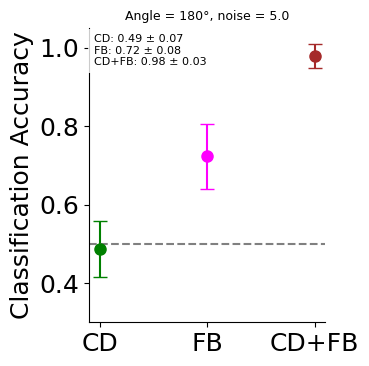

In [29]:
single_out = run_single(
    vel_array=vel_array,
    perturbed_vel_array=perturbed_vel_array,
    bump_vel_array=bump_vel_array,
    condition_angles=condition_angles,
    rel_bump_angles=relative_bump_angles_per_trial,
    kin_axis=kin_axis,
    nrn_axis=nrn_axis,
    fb_angle_deg=180,   
    noise_level=5.0,
    rng=np.random.default_rng(42)
)

In [43]:
angles_deg   = [0, 10, 45, 80, 90, 135, 180]     # FB relative to CD
noise_levels = [0, 10, 20, 35, 50]      # velocity noise SD
n_repeats    = 5

activity_window = (270, 320)
pos_labels = [0, 45, 90, 135]

n_nrn = 100
cd_lag = -80
fb_lag = 0

In [44]:
results = []

for angle in angles_deg:
    for noise in noise_levels:
        for rep in range(n_repeats):

            rng = np.random.default_rng(1000 + rep)

            full_act, cd_act, fb_act, _, _ = simulate_neural_activity(
                vel_array=vel_array,
                perturbed_vel_array=perturbed_vel_array,
                kin_axis=kin_axis,
                nrn_axis=nrn_axis,
                n_nrn=n_nrn,
                cd_lag=cd_lag,
                fb_lag=fb_lag,
                fb_angle_deg=angle,
                noise_level=noise,
                rng=rng
            )

            cd_acc_all   = []
            fb_acc_all   = []
            full_acc_all = []

            for pos in pos_labels:
                selected_trials, labels4 = build_labels_for_pos_vs_neg_and_bump(
                    condition_angles,
                    relative_bump_angles_per_trial,
                    pos_label=pos
                )

                if len(selected_trials) == 0:
                    continue

                X_cd = window_average(cd_act, nrn_axis, activity_window)[selected_trials]
                X_fb = window_average(fb_act, nrn_axis, activity_window)[selected_trials]
                X_f  = window_average(full_act, nrn_axis, activity_window)[selected_trials]

                cd_acc_all.append(run_binary_logreg_balanced(X_cd, labels4))
                fb_acc_all.append(run_binary_logreg_balanced(X_fb, labels4))
                full_acc_all.append(run_binary_logreg_balanced(X_f, labels4))

            cd_acc_all   = np.concatenate(cd_acc_all)
            fb_acc_all   = np.concatenate(fb_acc_all)
            full_acc_all = np.concatenate(full_acc_all)

            results.append(dict(
                angle=angle,
                noise=noise,
                repeat=rep,
                cd_acc_mean=cd_acc_all.mean(),
                fb_acc_mean=fb_acc_all.mean(),
                full_acc_mean=full_acc_all.mean(),
                delta_full_fb=full_acc_all.mean() - fb_acc_all.mean()
            ))

In [45]:
angles = np.unique([r["angle"] for r in results])
noises = np.unique([r["noise"] for r in results])

def get_metric(angle, noise, key):
    vals = [r[key] for r in results if r["angle"] == angle and r["noise"] == noise]
    return np.mean(vals), np.std(vals)

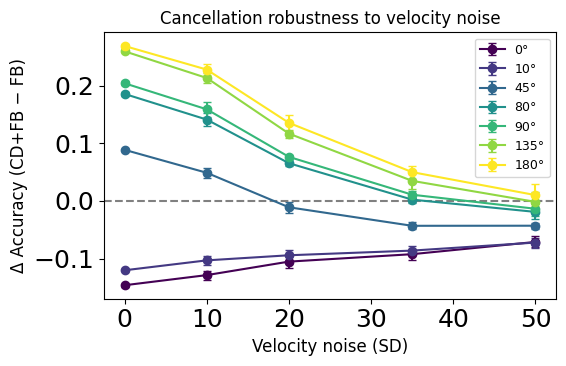

In [54]:
plt.figure(figsize=(6,4))

cmap = plt.get_cmap("viridis", len(angles))


for j, angle in enumerate(angles):
    means = []
    stds  = []
    for noise in noises:
        m, s = get_metric(angle, noise, "delta_full_fb")
        means.append(m)
        stds.append(s)
    plt.errorbar(
        noises, means, yerr=stds,
        marker='o',
        capsize=3,
        color=cmap(j),
        label=f"{angle}°"
    )
    

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Velocity noise (SD)",fontsize=12)
plt.ylabel("Δ Accuracy (CD+FB − FB)",fontsize=12)
plt.legend(fontsize=9)
plt.title("Cancellation robustness to velocity noise",fontsize=12)
plt.tight_layout()
fname = f"{figDir}{monkey}_robust_cancel_sim.pdf"
plt.savefig(fname, dpi=300)
plt.show()

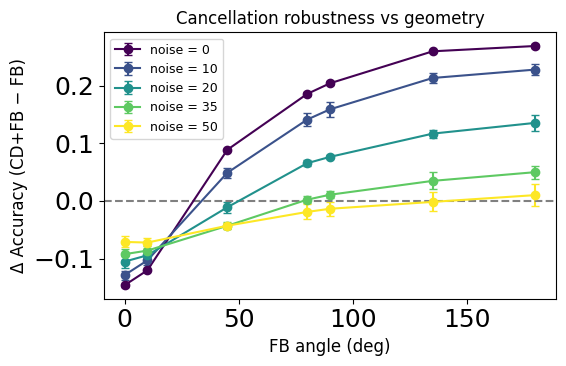

In [50]:
plt.figure(figsize=(6,4))

# choose a colormap
cmap = plt.get_cmap("viridis", len(noises))

for j, noise in enumerate(noises):
    means = []
    stds  = []
    for angle in angles:
        m, s = get_metric(angle, noise, "delta_full_fb")
        means.append(m)
        stds.append(s)

    plt.errorbar(
        angles, means, yerr=stds,
        marker='o',
        capsize=3,
        color=cmap(j),
        label=f"noise = {noise}"
    )

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("FB angle (deg)", fontsize=12)
plt.ylabel("Δ Accuracy (CD+FB − FB)", fontsize=12)
plt.title("Cancellation robustness vs geometry", fontsize=12)
plt.legend(fontsize=9)
plt.tight_layout()

fname = f"{figDir}{monkey}_robust_cancel_sim_angle_x.pdf"
plt.savefig(fname, dpi=300)
plt.show()

In [ ]:
heat = np.zeros((len(angles), len(noises)))

for i, a in enumerate(angles):
    for j, n in enumerate(noises):
        heat[i, j], _ = get_metric(a, n, "delta_full_fb")

plt.figure(figsize=(6,4))
plt.imshow(heat, aspect='auto', origin='lower')
plt.xticks(range(len(noises)), noises)
plt.yticks(range(len(angles)), angles)
plt.xlabel("Velocity noise")
plt.ylabel("FB angle (deg)")
plt.title("Δ Accuracy (CD+FB − FB)")
plt.colorbar(label="Δ Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import orth
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

def nans(shape):
    return np.full(shape, np.nan)

def generate_orth_weights(n_nrn=100, mu=0, sigma=1):
    W = np.random.normal(mu, sigma, size=(n_nrn, 4))
    W = orth(W)
    return W[:, :2], W[:, 2:]

# def rotate_vector(v, angle_rad):
#     r = np.random.randn(*v.shape)
#     r -= (np.dot(r, v) / np.dot(v, v)) * v
#     r /= np.linalg.norm(r)
#     v0 = v / np.linalg.norm(v)
#     return (np.cos(angle_rad) * v0 + np.sin(angle_rad) * r) * np.linalg.norm(v)
# def add_diag_gaussian_noise(activity, noise_level, sig_noise):
#     flat = activity.reshape(-1, activity.shape[-1])
#     noise = np.random.multivariate_normal(
#         np.zeros(flat.shape[-1]), sig_noise, flat.shape[0]
#     ) * noise_level
#     return (flat + noise).reshape(activity.shape)
# def add_noise_from_velocity(activity, vel, noise_level, sig_noise, eps=1e-3):
#     # vel: (trials, time, 2) aligned to activity
#     speed = np.linalg.norm(vel, axis=2)  # (trials, time)
#     # inv_speed = 1.0 / (speed + eps)
#     # scale = noise_level * inv_speed / inv_speed.mean()
#     scale = noise_level * speed / speed.mean()
#     flat = activity.reshape(-1, activity.shape[-1])
#     noise = np.random.multivariate_normal(
#         np.zeros(flat.shape[-1]), sig_noise, flat.shape[0]
#     ).reshape(activity.shape)
#     return activity + noise * scale[..., None]

def run_decoding_over_lags(activity, y, lag_axis, n_trials, n_nrn, sss, bin_ms):
    """
    activity: (n_trials, n_bins, n_nrn)
    y:        (n_trials, y_bins, 2)
    lag_axis: in ms
    bin_ms:   dataset_10ms.bin_width (ms)
    """
    r2 = nans((len(lag_axis), sss.n_splits))

    # convert each lag (ms) to shift (bins) relative to lag_axis[0]
    # so lag_axis[0] -> shift 0 bins
    shifts = np.round((lag_axis - lag_axis[0]) / bin_ms).astype(int)

    for j, shift in enumerate(shifts):
        start, end = shift, y.shape[1] + shift
        X = activity[:, start:end, :]

        for k, (tr, te) in enumerate(sss.split(range(n_trials))):
            r2[j, k] = LinearRegression().fit(
                X[tr].reshape(-1, n_nrn),
                y[tr].reshape(-1, 2)
            ).score(
                X[te].reshape(-1, n_nrn),
                y[te].reshape(-1, 2)
            )
    return r2

def peak_stats(r2, lag_axis):
    mean = np.mean(r2, axis=1)
    std  = np.std(r2, axis=1)
    i    = np.nanargmax(mean)
    return lag_axis[i], mean[i], mean, std

In [ ]:
# CODE CHUNK 1
# R² vs lag curves for aligned / orthogonal / opposite
# ------------------------- ranges / axes (same logic) --------------------------
trial_range = [-100, 120]
lag_range   = [-300, 300]
kin_range   = [trial_range[0] + lag_range[0] - 100,
               trial_range[1] + lag_range[1] + 100]

lag_axis = np.arange(lag_range[0], lag_range[1] + 1, 20)
nrn_axis = np.arange(trial_range[0] + lag_range[0], trial_range[1] + lag_range[1] + 1, dataset_10ms.bin_width)

df = dataset_10ms.make_trial_data(
    align_field='move_onset_time',
    align_range=kin_range,
    ignored_trials=~active_mask,
    allow_overlap=True
)

n_trials  = df['trial_id'].nunique()
vel_array = df['hand_vel'].to_numpy().reshape(active_n_trials, -1, 2)

kin_axis = np.arange(kin_range[0], kin_range[1] + 1, dataset_10ms.bin_width)
print('neural axis', nrn_axis[0], nrn_axis[-1])
print('kinematics axis', kin_axis[0], kin_axis[-1])

n_bins = len(nrn_axis)
cd_lag  = -80
fb_lag  =  30
cd_start = np.argwhere(kin_axis == nrn_axis[0] + (-cd_lag))[0, 0]
fb_start = np.argwhere(kin_axis == nrn_axis[0] + (-fb_lag))[0, 0]
zero_lag = np.argwhere(kin_axis == nrn_axis[0])[0, 0]

def add_noise_to_vel_after0(vel, time_axis_ms, noise_level, t0_ms=0):
    """
    vel: (trials, time, 2)
    Adds iid Gaussian noise to velocity only for time >= t0_ms.
    """
    after = (time_axis_ms >= t0_ms)[None, :, None]  # (1,time,1)
    noise = np.random.randn(*vel.shape) * noise_level
    return vel + noise * after

y = vel_array[:,
              np.argwhere(kin_axis == trial_range[0])[0, 0] : np.argwhere(kin_axis == trial_range[1])[0, 0],
              :]

In [ ]:
noise_level = 5   # single noise level for this figure
vel0_noisy = add_noise_to_vel_after0(vel_array, kin_axis[:-1], noise_level, t0_ms=0)
vel1_noisy = add_noise_to_vel_after0(vel_array, kin_axis[:-1], noise_level, t0_ms=0)

cd_idx = np.arange(n_bins) + cd_start
fb_idx = np.arange(n_bins) + fb_start
vel_cd_noisy = vel0_noisy[:, cd_idx, :]
vel_fb_noisy = vel1_noisy[:, fb_idx, :]

# real target
y = vel_array[:,
              np.argwhere(kin_axis == trial_range[0])[0, 0] : np.argwhere(kin_axis == trial_range[1])[0, 0],
              :]

In [ ]:
vel_cd = vel_array[:, cd_idx, :]
vel_fb = vel_array[:, fb_idx, :]
def add_noise_to_nrn_after0(activity, time_axis_ms, noise_level, sig_noise, t0_ms=0):
    """
    Add Gaussian noise to neural activity only for time >= t0_ms.
    activity: (trials, time, n_nrn)
    time_axis_ms: (time,) aligned to activity's time dimension (e.g., nrn_axis)
    """
    T = activity.shape[1]
    time_use = time_axis_ms[:T]  # safe if off-by-one

    after = (time_use >= t0_ms).astype(float)[None, :]          # (1, time)
    scale = noise_level * after                                  # (1, time)

    flat = activity.reshape(-1, activity.shape[-1])
    noise = np.random.multivariate_normal(
        mean=np.zeros(flat.shape[-1]),
        cov=sig_noise,
        size=flat.shape[0]
    ).reshape(activity.shape)

    return activity + noise * scale[..., None]   

In [ ]:
# --- parameters ---
n_nrn   = 100

cond_list = ["aligned", "orthogonal", "opposite"]

n_splits = 20
sss = ShuffleSplit(n_splits=n_splits, random_state=42)

# --- weights ---
nrn_weight_cd, nrn_weight_fb_orth = generate_orth_weights(n_nrn)
# --- projections ---
nrn_weight_cd_halved = nrn_weight_cd * .5
sig_noise = np.eye(n_nrn)

curve_store = {}

for cond in cond_list:

    if cond == "aligned":
        nrn_weight_fb = nrn_weight_cd.copy()
    elif cond == "orthogonal":
        nrn_weight_fb = nrn_weight_fb_orth
    elif cond == "opposite":
        nrn_weight_fb = -nrn_weight_cd


    cd_nrn_activity = vel_cd_noisy @ nrn_weight_cd.T
    fb_nrn_activity = vel_fb_noisy @ nrn_weight_fb.T
    nrn_activity    = cd_nrn_activity + fb_nrn_activity

    # cd_nrn_activity = vel_cd @ nrn_weight_cd_halved.T
    # fb_nrn_activity = vel_fb @ nrn_weight_fb.T

    # sig_noise = np.eye(n_nrn)
    # noise_level = 5

    # # Use nrn_axis as the time axis for these activities (length n_bins)
    # noisy_cd = add_noise_to_nrn_after0(cd_nrn_activity, nrn_axis, noise_level, sig_noise, t0_ms=0)
    # noisy_fb = add_noise_to_nrn_after0(fb_nrn_activity, nrn_axis, noise_level, sig_noise, t0_ms=0)

    # # combined signal should use the SAME noise-gating logic
    # noisy_all = noisy_cd + noisy_fb

    # noisy_all = add_diag_gaussian_noise(nrn_activity, noise_level, sig_noise)
    # noisy_cd  = add_diag_gaussian_noise(cd_nrn_activity, noise_level, sig_noise)
    # noisy_fb  = add_diag_gaussian_noise(fb_nrn_activity, noise_level, sig_noise)

    # # velocities aligned to each activity stream
    # noisy_cd = add_noise_from_velocity(cd_nrn_activity, vel_cd, noise_level, sig_noise)
    # noisy_fb = add_noise_from_velocity(fb_nrn_activity, vel_fb, noise_level, sig_noise)

    # for the combined signal, use a combined speed proxy aligned to nrn_activity bins
    # vel_all = 0.5 * (vel_cd + vel_fb)   # simple and aligned; you could also use vel_cd or vel_fb alone
    # vel_all = vel_zero_lag
    # noisy_all = add_noise_from_velocity(nrn_activity, vel_all, noise_level, sig_noise)

    r2_all = run_decoding_over_lags(nrn_activity, y, lag_axis, n_trials, n_nrn, sss, dataset_10ms.bin_width)
    r2_cd  = run_decoding_over_lags(cd_nrn_activity,  y, lag_axis, n_trials, n_nrn, sss, dataset_10ms.bin_width)
    r2_fb  = run_decoding_over_lags(fb_nrn_activity,  y, lag_axis, n_trials, n_nrn, sss, dataset_10ms.bin_width)

    curve_store[cond] = {
        "all": peak_stats(r2_all, lag_axis)[2:],
        "cd":  peak_stats(r2_cd,  lag_axis)[2:],
        "fb":  peak_stats(r2_fb,  lag_axis)[2:]
    }



In [ ]:
for cond in cond_list:

    mean_all, std_all = curve_store[cond]["all"]
    mean_cd,  std_cd  = curve_store[cond]["cd"]
    mean_fb,  std_fb  = curve_store[cond]["fb"]

    fig, ax = plt.subplots(figsize=(5.5, 4))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.plot(lag_axis, mean_all, color='brown', lw=2, label='CD+FB')
    ax.fill_between(lag_axis, mean_all - std_all, mean_all + std_all,
                    color='brown', alpha=0.25)

    ax.plot(lag_axis, mean_cd, color='green', lw=2, label='CD')
    ax.fill_between(lag_axis, mean_cd - std_cd, mean_cd + std_cd,
                    color='green', alpha=0.25)

    ax.plot(lag_axis, mean_fb, color='magenta', lw=2, label='FB')
    ax.fill_between(lag_axis, mean_fb - std_fb, mean_fb + std_fb,
                    color='magenta', alpha=0.25)

    # optional lag markers
    ax.axvline(cd_lag, color='k', linestyle='--')
    ax.axvline(fb_lag, color='k', linestyle='--')

    ax.set_xlabel("Time lag (ms)")
    ax.set_ylabel("R²")
    ax.set_ylim([-0.1, 1.0])
    ax.set_title(cond)

    plt.tight_layout()
    plt.savefig(figDir + monkey + "_" + cond + "_sim_r2.pdf", dpi='figure')
    plt.show()
# noise before movement onset

In [ ]:
def mean_between_lags(mean_curve, lag_axis, lag_a, lag_b):
    lo, hi = (lag_a, lag_b) if lag_a <= lag_b else (lag_b, lag_a)
    m = (lag_axis >= lo) & (lag_axis <= hi)
    if not np.any(m):
        return np.nan
    return np.mean(mean_curve[m])

In [ ]:
lag_axis_win = np.arange(-80, +40  + 1, 20)
lag_axis_win

In [ ]:
def run_decoding_over_lags_window(activity, y, lag_axis_win, lag_axis0, n_trials, n_nrn, sss, bin_ms):

    r2 = nans((len(lag_axis_win), sss.n_splits))

    # Convert each requested lag (ms) -> shift (bins) relative to lag_axis0
    shifts = np.round((lag_axis_win - lag_axis0) / bin_ms).astype(int)

    for j, shift in enumerate(shifts):
        start, end = shift, y.shape[1] + shift  # align activity window to y length
        X = activity[:, start:end, :]           # (n_trials, y_time, n_nrn)

        for k, (tr, te) in enumerate(sss.split(range(n_trials))):
            X_train = X[tr].reshape(-1, n_nrn)
            X_test  = X[te].reshape(-1, n_nrn)

            y_train = y[tr].reshape(-1, 2)
            y_test  = y[te].reshape(-1, 2)

            r2[j, k] = LinearRegression().fit(X_train, y_train).score(X_test, y_test)

    return r2

In [ ]:
def rotate_2d_vectors(W, angle_deg):

    if angle_deg == 0:
        return W.copy()
    if angle_deg == 180:
        return -W.copy()

    th = np.deg2rad(angle_deg)
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    return W @ R.T

In [ ]:
angle_deg_list = np.array([0, 45, 90, 100, 135, 170, 180])

noise_levels = np.array([0, 2, 5, 10, 20])

n_splits = 20
sss = ShuffleSplit(n_splits=n_splits, random_state=42)

# noises to two copies of velocities


# --- base weights ---
nrn_weight_cd, _ = generate_orth_weights(n_nrn)

sig_noise = np.eye(n_nrn)

# -------- allocate storage (full curves) ----------
n_ang   = len(angle_deg_list)
n_noise = len(noise_levels)
n_lag   = len(lag_axis_win)

r2_all_mean = nans((n_ang, n_noise, n_lag))
r2_all_std  = nans((n_ang, n_noise, n_lag))

r2_cd_mean  = nans((n_ang, n_noise, n_lag))
r2_cd_std   = nans((n_ang, n_noise, n_lag))

r2_fb_mean  = nans((n_ang, n_noise, n_lag))
r2_fb_std   = nans((n_ang, n_noise, n_lag))

# -------- allocate storage (peak + between-peaks metrics) ----------
cd_peak_lag = nans((n_ang, n_noise))
cd_peak_r2  = nans((n_ang, n_noise))

fb_peak_lag = nans((n_ang, n_noise))
fb_peak_r2  = nans((n_ang, n_noise))

all_peak_lag = nans((n_ang, n_noise))   # optional
all_peak_r2  = nans((n_ang, n_noise))   # optional

all_mean_between_peaks = nans((n_ang, n_noise))  # what you asked for
all_at_cd_peak = nans((n_ang, n_noise))          # optional but useful
all_at_fb_peak = nans((n_ang, n_noise))          # optional but useful

# (optional) keep your old peak-delta metrics too
delta_peak_r2  = nans((n_ang, n_noise))
delta_peak_lag = nans((n_ang, n_noise))

# -------- simulate for each angle ----------
for i_ang, angle in enumerate(angle_deg_list):

    nrn_weight_fb = rotate_2d_vectors(nrn_weight_cd, angle)

    for i_n, noise_level in enumerate(noise_levels):
        print(f"Angle {i_ang+1}/{n_ang}, Noise {i_n+1}/{n_noise}")
        vel0_temp = add_noise_to_vel_after0(vel_array, kin_axis[:-1], noise_level, t0_ms=0)
        cd_idx = np.arange(n_bins) + cd_start
        fb_idx = np.arange(n_bins) + fb_start
        vel_cd_noisy = vel0_temp[:, cd_idx, :]
        vel_fb_noisy = vel0_temp[:, fb_idx, :]

        cd_nrn_activity = vel_cd_noisy @ nrn_weight_cd.T
        fb_nrn_activity = vel_fb_noisy @ nrn_weight_fb.T
        nrn_activity = cd_nrn_activity + fb_nrn_activity


        # ---- decode only within lag_axis_win ----
        r2_all = run_decoding_over_lags_window(
            cd_nrn_activity, y, lag_axis_win, lag_axis0=lag_axis[0],
            n_trials=n_trials, n_nrn=n_nrn, sss=sss, bin_ms=dataset_10ms.bin_width
        )
        r2_cd_ = run_decoding_over_lags_window(
            fb_nrn_activity, y, lag_axis_win, lag_axis0=lag_axis[0],
            n_trials=n_trials, n_nrn=n_nrn, sss=sss, bin_ms=dataset_10ms.bin_width
        )
        r2_fb_ = run_decoding_over_lags_window(
            nrn_activity, y, lag_axis_win, lag_axis0=lag_axis[0],
            n_trials=n_trials, n_nrn=n_nrn, sss=sss, bin_ms=dataset_10ms.bin_width
        )

        # ---- store full curves ----
        all_mean = np.mean(r2_all, axis=1); all_std = np.std(r2_all, axis=1)
        cd_mean  = np.mean(r2_cd_, axis=1); cd_std  = np.std(r2_cd_, axis=1)
        fb_mean  = np.mean(r2_fb_, axis=1); fb_std  = np.std(r2_fb_, axis=1)

        r2_all_mean[i_ang, i_n, :] = all_mean
        r2_all_std[i_ang, i_n, :]  = all_std
        r2_cd_mean[i_ang, i_n, :]  = cd_mean
        r2_cd_std[i_ang, i_n, :]   = cd_std
        r2_fb_mean[i_ang, i_n, :]  = fb_mean
        r2_fb_std[i_ang, i_n, :]   = fb_std

        # ---- peak stats for CD, FB, and ALL ----
        cd_pk_lag, cd_pk_r2, _, _ = peak_stats(r2_cd_, lag_axis_win)
        fb_pk_lag, fb_pk_r2, _, _ = peak_stats(r2_fb_, lag_axis_win)
        all_pk_lag, all_pk_r2, _, _ = peak_stats(r2_all, lag_axis_win)

        cd_peak_lag[i_ang, i_n] = cd_pk_lag
        cd_peak_r2[i_ang, i_n]  = cd_pk_r2
        fb_peak_lag[i_ang, i_n] = fb_pk_lag
        fb_peak_r2[i_ang, i_n]  = fb_pk_r2
        all_peak_lag[i_ang, i_n] = all_pk_lag
        all_peak_r2[i_ang, i_n]  = all_pk_r2

        # ---- your requested metric: mean CD+FB between component peak times ----
        all_mean_between_peaks[i_ang, i_n] = mean_between_lags(all_mean, lag_axis_win, cd_pk_lag, fb_pk_lag)

        # ---- optional: evaluate CD+FB at each component’s peak lag ----
        # (helps if you later want “does CD+FB preserve both peaks?”)
        i_cd = np.argmin(np.abs(lag_axis_win - cd_pk_lag))
        i_fb = np.argmin(np.abs(lag_axis_win - fb_pk_lag))
        all_at_cd_peak[i_ang, i_n] = all_mean[i_cd]
        all_at_fb_peak[i_ang, i_n] = all_mean[i_fb]

        # ---- keep your old delta-peak (ALL vs FB) if you want ----
        delta_peak_r2[i_ang, i_n]  = all_pk_r2 - fb_pk_r2
        delta_peak_lag[i_ang, i_n] = fb_pk_lag - all_pk_lag

In [ ]:
save_path = f"{monkey}_angle_noise_fullcurves_and_metrics.npz"

np.savez(
    save_path,
    angle_deg_list=angle_deg_list,
    noise_levels=noise_levels,
    lag_axis_win=lag_axis_win,

    # full curves
    r2_all_mean=r2_all_mean, r2_all_std=r2_all_std,
    r2_cd_mean=r2_cd_mean,   r2_cd_std=r2_cd_std,
    r2_fb_mean=r2_fb_mean,   r2_fb_std=r2_fb_std,

    # peaks
    cd_peak_lag=cd_peak_lag, cd_peak_r2=cd_peak_r2,
    fb_peak_lag=fb_peak_lag, fb_peak_r2=fb_peak_r2,
    all_peak_lag=all_peak_lag, all_peak_r2=all_peak_r2,

    # between-peaks and eval-at-peaks
    all_mean_between_peaks=all_mean_between_peaks,
    all_at_cd_peak=all_at_cd_peak,
    all_at_fb_peak=all_at_fb_peak,

    # optional deltas
    delta_peak_r2=delta_peak_r2,
    delta_peak_lag=delta_peak_lag,

    # tiny metadata 
    cd_lag=cd_lag, fb_lag=fb_lag,
    bin_width_ms=dataset_10ms.bin_width,
)
print("saved:", save_path)

In [ ]:
all_mean_between_peaks

In [ ]:
plt.figure(figsize=(5.5, 4))
for i, ang in enumerate(angle_deg_list):
    plt.plot(noise_levels, all_mean_between_peaks[i], marker='o', label=f"{ang}°")

plt.xlabel("Noise level")
plt.ylabel("Mean R² of CD+FB between CD-peak and FB-peak lags")
plt.legend(title="Angle", frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
band_lo = min(cd_lag, fb_lag)
band_hi = max(cd_lag, fb_lag)
band_mask = (lag_axis_win >= band_lo) & (lag_axis_win <= band_hi)

bandmean_all = np.mean(r2_all_mean[:, :, band_mask], axis=2)  # (n_angles, n_noise)
bandmean_fb  = np.mean(r2_fb_mean[:, :, band_mask], axis=2)   # (n_angles, n_noise)

bandgain_all_vs_fb = bandmean_all - bandmean_fb

In [ ]:
plt.figure(figsize=(5.5, 4))
for i, ang in enumerate(angle_deg_list):
    plt.plot(noise_levels, bandgain_all_vs_fb[i], marker='o', label=f"{ang}°")

plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Noise level")
plt.ylabel("Δ mean R² (CD+FB − FB) in-between lags")
plt.title("Integration gain vs noise")
plt.legend(title="Angle", frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
i = 2  # pick an angle index, e.g. 0° or 90°
plt.figure(figsize=(5.5,4))
plt.plot(noise_levels, cd_peak_r2[i], marker='o', label="CD peak R²")
plt.plot(noise_levels, fb_peak_r2[i], marker='o', label="FB peak R²")
plt.plot(noise_levels, all_mean_between_peaks[i], marker='o', label="CD+FB mean between peaks")
plt.xlabel("Noise level")
plt.ylabel("R²")
plt.title(f"Angle = {angle_deg_list[i]}°")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Simulation

In [ ]:
trial_range = [-100, 1000]
lag_range = [-300, 300]
kin_range = [trial_range[0] + lag_range[0] + (-200), trial_range[1] + lag_range[1] + (+200)]                                
lag_axis = np.arange(lag_range[0], lag_range[1]+1, 10)
nrn_axis = np.arange(trial_range[0]+lag_range[0], trial_range[1]+lag_range[1]+1, 10)
# To predict trial_range, we need wider neural_range, which requires wider kin_range

df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=kin_range, ignored_trials=~active_mask, allow_overlap=True)
n_trials = df['trial_id'].nunique()
# acc_array = df['hand_acc'].to_numpy().reshape(active_n_trials, -1, 2)
vel_array = df['hand_vel'].to_numpy().reshape(active_n_trials, -1, 2)

kin_axis = np.arange(kin_range[0], kin_range[1]+1, dataset_10ms.bin_width)
print('neural axis',nrn_axis[0], nrn_axis[-1])
print('kinematics axis',kin_axis[0], kin_axis[-1])

In [ ]:
mu, sigma = 0,1
n_nrn = 100

def generate_orth_weights():
    weights_raw = np.random.normal(mu, sigma, size=(n_nrn, 4))
    weights_orth = orth(weights_raw)
    return weights_orth[:, 0:2], weights_orth[:, 2:4]  # CD weights, FB weights
def rotate_vector(v, angle_rad):
    """Rotate vector v by angle_rad in a random orthogonal direction."""
    # Generate a random vector
    rand_vec = np.random.randn(*v.shape)
    # Make it orthogonal to v
    rand_vec -= (np.dot(rand_vec, v) / np.dot(v, v)) * v
    rand_vec /= np.linalg.norm(rand_vec)  # normalize
    
    # Construct rotated vector in plane (v, rand_vec)
    v_norm = v / np.linalg.norm(v)
    rotated = np.cos(angle_rad) * v_norm + np.sin(angle_rad) * rand_vec
    return rotated * np.linalg.norm(v)  # scale back to original magnitude

nrn_weight_cd_save, nrn_weight_fb_save = generate_orth_weights()
nrn_weights_save = np.stack([nrn_weight_cd_save, nrn_weight_fb_save], axis=0)

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_runs = 1

cd_lag = -100
fb_lag = 50
noise_level = 5
noise_lv = "hi"
type = "approx_oppo"

for b in np.arange(0,n_runs):
    if b == 0:
        nrn_weight_cd = nrn_weight_cd_save
        nrn_weight_fb = nrn_weight_fb_save
    else:
        nrn_weight_cd, nrn_weight_fb = generate_orth_weights()
    if type == "align":
        nrn_weight_fb = nrn_weight_cd.copy()
    elif type == "oppo":
        nrn_weight_fb = -nrn_weight_cd
    elif type == "approx_align":
        angle = np.deg2rad(10)  # 10 degrees
        nrn_weight_fb = np.array([rotate_vector(v, angle) for v in nrn_weight_cd])
    elif type == "approx_oppo":
        angle = np.deg2rad(180 - 10)  # 170 degrees
        nrn_weight_fb = np.array([rotate_vector(v, angle) for v in nrn_weight_cd])

    n_bins = len(nrn_axis)
    nrn_activity = nans([n_trials, n_bins, n_nrn])
    cd_nrn_activity = nans([n_trials, n_bins, n_nrn])
    fb_nrn_activity = nans([n_trials, n_bins, n_nrn])

    # Precompute index offsets once
    cd_start = np.argwhere(kin_axis == nrn_axis[0] + (-cd_lag))[0, 0]
    fb_start = np.argwhere(kin_axis == nrn_axis[0] + (-fb_lag))[0, 0]

    cd_idx = np.arange(n_bins) + cd_start
    fb_idx = np.arange(n_bins) + fb_start

    # Slice velocity arrays in one go
    vel_cd = vel_array[:, cd_idx, :]   # shape (n_trials, n_bins, 2)
    vel_fb = vel_array[:, fb_idx, :]   # shape (n_trials, n_bins, 2)

    # Project onto neuron weights using matrix multiply (batch matmul)
    cd_nrn_activity = vel_cd @ nrn_weight_cd.T  # (n_trials, n_bins, n_nrn)
    fb_nrn_activity = vel_fb @ nrn_weight_fb.T  # (n_trials, n_bins, n_nrn)

    # Combine
    nrn_activity = cd_nrn_activity + fb_nrn_activity

    # Add Gaussian noise
    nrn_activity_flat = nrn_activity.reshape(-1,n_nrn)
    sig_noise = np.zeros((n_nrn,n_nrn))
    np.fill_diagonal(sig_noise,1)
    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    noisy_nrn_activity = (nrn_activity_flat+noise).reshape(nrn_activity.shape)

    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    cd_nrn_activity_flat = cd_nrn_activity.reshape(-1,n_nrn)
    noisy_cd_nrn_activity = (cd_nrn_activity_flat+noise).reshape(cd_nrn_activity.shape)

    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    fb_nrn_activity_flat = fb_nrn_activity.reshape(-1,n_nrn)
    noisy_fb_nrn_activity = (fb_nrn_activity_flat+noise).reshape(fb_nrn_activity.shape)    

    # noisy_nrn_activity = noisy_cd_nrn_activity + noisy_fb_nrn_activity
    n_splits = 20
    r2_array = nans([len(lag_axis), n_splits]); 
    cd_r2 = nans([len(lag_axis), n_splits]); fb_r2 = nans([len(lag_axis), n_splits])
    y = vel_array[:,np.argwhere(kin_axis==trial_range[0])[0,0]:np.argwhere(kin_axis==trial_range[1])[0,0],:]
    # y_reshaped = y.reshape(-1,2)
    for j in range(len(lag_axis)):
        start, end = j, y.shape[1] + j
        def run_decoding(activity):
            r2_arr = nans([n_splits])
            X = activity[:, start:end, :]
            sss = ShuffleSplit(n_splits=n_splits,random_state = 42)
            for k,(training_set, test_set) in enumerate(sss.split(range(0,n_trials))):
                X_train = X[training_set,:,:].reshape(-1,n_nrn)
                X_test = X[test_set,:,:].reshape(-1,n_nrn)
                y_train = y[training_set,:,:].reshape(-1,2)
                y_test = y[test_set,:,:].reshape(-1,2)
                r2_arr[k] =LinearRegression().fit(X_train, y_train).score(X_test, y_test)
            return r2_arr
        cd_r2[j,:] = run_decoding(noisy_cd_nrn_activity)
        fb_r2[j,:] = run_decoding(noisy_fb_nrn_activity)
        r2_array[j,:] = run_decoding(noisy_nrn_activity)

In [ ]:
np.savez(str(monkey)+"_sim_"+str(type),\
         noisy_cd_nrn_activity = noisy_cd_nrn_activity, noisy_fb_nrn_activity = noisy_fb_nrn_activity, \
         noisy_nrn_activity = noisy_nrn_activity,\
         cd_r2 = cd_r2,fb_r2 = fb_r2, \
         r2_array = r2_array, nrn_weights_save=nrn_weights_save)

In [ ]:
# fig, ax = plt.subplots(figsize=(4,3))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# tr_idx = 164
# nrn_idx = 10

# plt.plot(nrn_axis,cd_nrn_activity[tr_idx,:,nrn_idx],color = 'green',label = 'cd signal')
# plt.plot(nrn_axis,fb_nrn_activity[tr_idx,:,nrn_idx],color = 'magenta',label = 'fb signal')
# plt.plot(nrn_axis,nrn_activity[tr_idx,:,nrn_idx],color = 'brown',label = 'sum signal')
# plt.plot(nrn_axis,noisy_nrn_activity[tr_idx,:,nrn_idx],color = 'gray',alpha=0.8,label = 'noisy signal')
# # plt.legend(fontsize=8)
# plt.xlim([-200, 1200])
# plt.axvline(0,color = 'k', linestyle='--')
# plt.tight_layout()
# plt.savefig(figDir + monkey+"_"+type+"_example_nrn_"+noise_lv+"_noise.pdf",dpi = 'figure')
# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Compute means and standard deviations
mean_r2 = np.mean(r2_array, axis=1)
std_r2 = np.std(r2_array, axis=1)

mean_cd = np.mean(cd_r2, axis=1)
std_cd = np.std(cd_r2, axis=1)

mean_fb = np.mean(fb_r2, axis=1)
std_fb = np.std(fb_r2, axis=1)

# Plot means
plt.plot(lag_axis, mean_r2, color='brown')
plt.plot(lag_axis, mean_cd, color='green', linestyle='--',alpha=0.5)
plt.plot(lag_axis, mean_fb, color='magenta',linestyle='--',alpha=0.5)

# Fill between mean ± std
plt.fill_between(lag_axis, mean_r2 - std_r2, mean_r2 + std_r2, color='brown', alpha=0.3)
plt.fill_between(lag_axis, mean_cd - std_cd, mean_cd + std_cd, color='green', alpha=0.3)
plt.fill_between(lag_axis, mean_fb - std_fb, mean_fb + std_fb, color='magenta', alpha=0.3)

plt.axvline(cd_lag, color = 'k', linestyle='--')
plt.axvline(fb_lag, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R²')
plt.ylim([-0.1, 1.0])
plt.tight_layout()
plt.savefig(figDir + monkey + "_"+type+"_sim_r2.pdf", dpi = 'figure')
plt.show()
# plt.hist(ang_runs)
# plt.xlabel("Angle (deg)")
# plt.ylabel('Frequency')

## Perturbation

In [82]:
trial_range = [-100, 1000]
# trial_range = [-100, 1100]

lag_range = [-300, 300]
kin_range = [trial_range[0] + lag_range[0] + (-200), trial_range[1] + lag_range[1] + (+500)]                                
lag_axis = np.arange(lag_range[0], lag_range[1]+1, 10)
nrn_axis = np.arange(trial_range[0]+lag_range[0], trial_range[1]+lag_range[1]+1, 10)
# To predict trial_range, we need wider neural_range, which requires wider kin_range

df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=kin_range, ignored_trials=~active_mask, allow_overlap=True)
n_trials = df['trial_id'].nunique()
vel_array = df['hand_vel'].to_numpy().reshape(active_n_trials, -1, 2)

kin_axis = np.arange(kin_range[0], kin_range[1], dataset_10ms.bin_width)
print('neural axis',nrn_axis[0], nrn_axis[-1])
print('kinematics axis',kin_axis[0], kin_axis[-1])

Allowed 239 overlapping trials.


neural axis -400 1300
kinematics axis -600 1790


In [83]:
cond_dir_dict = (
    dataset_10ms.trial_info.cond_dir
).to_dict()

In [84]:
# Parameters
perturb_time_ms = 325
perturb_width = 40
bump_strength = 20  # fixed magnitude
relative_bump_angles = np.array([0, 90, 180, 270])
relative_bump_angles_per_trial = np.zeros(n_trials)
# absolute_bump_angles = np.zeros(n_trials)
condition_angles = np.zeros(n_trials)


# Time setup
perturb_idx = np.argmin(np.abs(kin_axis - perturb_time_ms))
gaussian_bump = np.exp(-0.5 * ((kin_axis - perturb_time_ms) / perturb_width) ** 2)  # shape: [time]

# Output arrays
perturbed_vel_array = vel_array.copy()
bump_vel_array = np.full_like(vel_array, np.nan)

for trial in range(n_trials):
    # Get base direction in degrees
    base_dir_deg = cond_dir_dict[df['trial_id'].unique()[trial]]  # e.g., 0–315

    # Pick relative bump angle randomly
    rel_bump_angle = np.random.choice(relative_bump_angles)
    bump_dir_deg = (base_dir_deg + rel_bump_angle) % 360
    
    condition_angles[trial] = base_dir_deg%360
    relative_bump_angles_per_trial[trial] = rel_bump_angle
    # absolute_bump_angles[trial] = bump_dir_deg

    # Convert bump direction to unit vector
    bump_dir_rad = np.deg2rad(bump_dir_deg)
    bump_vector = np.array([np.cos(bump_dir_rad), np.sin(bump_dir_rad)])  # shape: (2,)

    # Create bump signal
    bump = gaussian_bump[:, None] * bump_vector[None, :] * bump_strength  # shape: [time, 2]

    # Store
    bump_vel_array[trial, :, :] = bump
    perturbed_vel_array[trial, :, :] += bump

(0.0, 500.0)

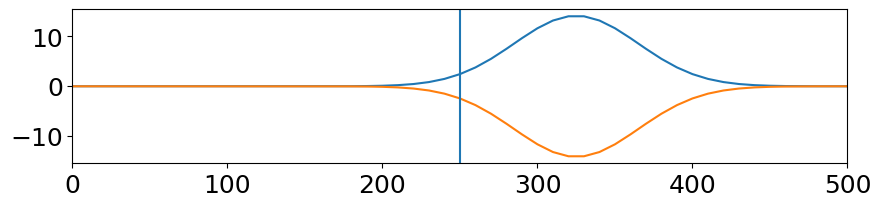

In [85]:
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(kin_axis,bump)
plt.axvline([250])
plt.xlim([0, 500])

Text(0, 0.5, 'Hand velocity (cm/s)')

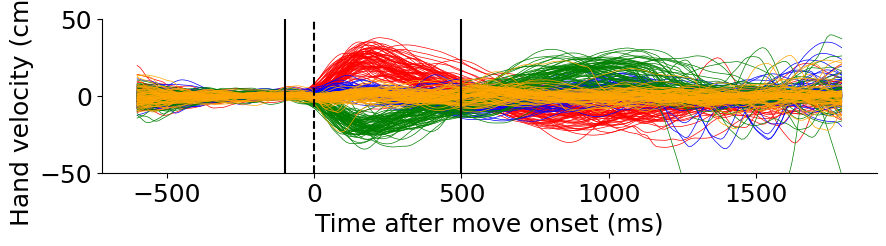

In [86]:
all_dir =  np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
plot_dir = [0.0, 90.0, 180.0, 270.0] 
dir_idx = [np.argwhere(all_dir==dir)[0,0] for dir in plot_dir]

plot_dim = 0 # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(10,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(plot_dir)):
    indices = np.array([np.argwhere(active_cond_dict==dir_idx[i])]).flatten()
    plt.plot(kin_axis,vel_array[indices,:,plot_dim].T, color = colors[i],linewidth=0.5)
plt.axvline([0],color='k',linestyle='--')
plt.axvline([-100],color='k')
plt.axvline([500],color='k')
plt.ylim([-50, 50])
plt.xlabel('Time after move onset (ms)')
plt.ylabel('Hand velocity (cm/s)')


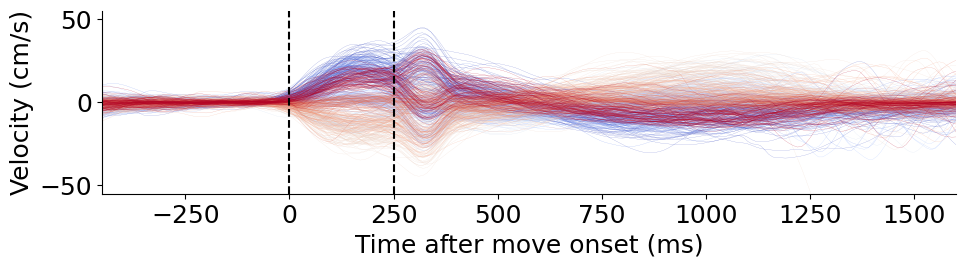

In [87]:

plot_dim = 0 # plot x velocity
all_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
plot_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
dir_idx = [np.argwhere(all_dirs==dir)[0,0] for dir in plot_dirs]
cmap = plt.get_cmap('coolwarm',len(plot_dirs))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(all_dirs))]

fig, ax = plt.subplots(figsize=(10,3))
# fig, ax = plt.subplots(figsize=(5,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(plot_dirs)):
    indices = np.array([np.argwhere(active_cond_dict==dir_idx[i])]).flatten()
    plt.plot(kin_axis,perturbed_vel_array[indices,:,plot_dim].T, color = custom_palette[i],linewidth=0.1)
    # plt.plot(kin_axis,vel_array[indices,:,plot_dim].T, color = custom_palette[i],linewidth=0.1)
plt.axvline([0],color='k',linestyle='--')
plt.xlim([-450, 1600])
# plt.xlim([-350, 1700])
# plt.xlim([0, 500])
plt.ylim([-55, 55])
# plt.axvline([150],color='k')
plt.axvline([250],color='k',linestyle='--')
# plt.axvline([350],color='k')
# plt.axvline([450],color='k')
# plt.axvline([550],color='k')
# plt.axvline([650],color='k')
plt.xlabel('Time after move onset (ms)')
plt.ylabel('Velocity (cm/s)')
# plt.title('perturbation added')
plt.tight_layout()
plt.savefig(figDir + monkey + '_activebump_simulation_vel.pdf',dpi = 'figure')

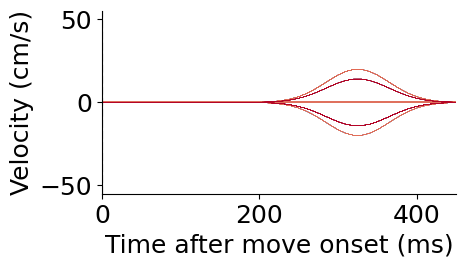

In [22]:

plot_dim = 0 # plot x velocity
all_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
plot_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
dir_idx = [np.argwhere(all_dirs==dir)[0,0] for dir in plot_dirs]
cmap = plt.get_cmap('coolwarm',len(plot_dirs))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(all_dirs))]

fig, ax = plt.subplots(figsize=(5,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(plot_dirs)):
    indices = np.array([np.argwhere(active_cond_dict==dir_idx[i])]).flatten()
    plt.plot(kin_axis,bump_vel_array[indices,:,plot_dim].T, color = custom_palette[i],linewidth=0.1)
plt.axvline([0],color='k',linestyle='--')
plt.xlim([0, 450])
plt.ylim([-55, 55])
# plt.axvline([-100],color='k')
# plt.axvline([500],color='k')
plt.xlabel('Time after move onset (ms)')
plt.ylabel('Velocity (cm/s)')
# plt.title('perturbation added')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_activebump_simulation_vel.pdf',dpi = 'figure')

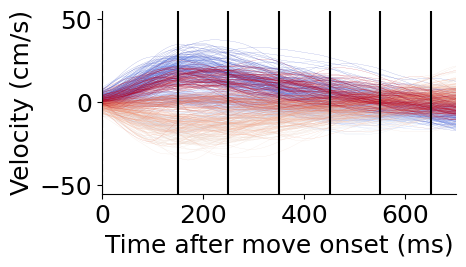

In [23]:

plot_dim = 0 # plot x velocity
all_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
plot_dirs = np.array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0])
dir_idx = [np.argwhere(all_dirs==dir)[0,0] for dir in plot_dirs]
cmap = plt.get_cmap('coolwarm',len(plot_dirs))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(all_dirs))]

fig, ax = plt.subplots(figsize=(5,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(plot_dirs)):
    indices = np.array([np.argwhere(active_cond_dict==dir_idx[i])]).flatten()
    plt.plot(kin_axis,vel_array[indices,:,plot_dim].T, color = custom_palette[i],linewidth=0.1)
plt.axvline([0],color='k',linestyle='--')
plt.xlim([0, 700])
plt.ylim([-55, 55])
plt.axvline([150],color='k')
plt.axvline([250],color='k')
plt.axvline([350],color='k')
plt.axvline([450],color='k')
plt.axvline([550],color='k')
plt.axvline([650],color='k')

plt.xlabel('Time after move onset (ms)')
plt.ylabel('Velocity (cm/s)')
# plt.title('perturbation added')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_activebump_simulation_vel.pdf',dpi = 'figure')

In [ ]:
mu, sigma = 0,1
n_nrn = 100

def generate_orth_weights():
    weights_raw = np.random.normal(mu, sigma, size=(n_nrn, 4))
    weights_orth = orth(weights_raw)
    return weights_orth[:, 0:2], weights_orth[:, 2:4]  # CD weights, FB weights
def rotate_vector(v, angle_rad):
    """Rotate vector v by angle_rad in a random orthogonal direction."""
    # Generate a random vector
    rand_vec = np.random.randn(*v.shape)
    # Make it orthogonal to v
    rand_vec -= (np.dot(rand_vec, v) / np.dot(v, v)) * v
    rand_vec /= np.linalg.norm(rand_vec)  # normalize
    
    # Construct rotated vector in plane (v, rand_vec)
    v_norm = v / np.linalg.norm(v)
    rotated = np.cos(angle_rad) * v_norm + np.sin(angle_rad) * rand_vec
    return rotated * np.linalg.norm(v)  # scale back to original magnitude

nrn_weight_cd_save, nrn_weight_fb_save = generate_orth_weights()
nrn_weights_save = np.stack([nrn_weight_cd_save, nrn_weight_fb_save], axis=0)

In [ ]:
def rotate_2d_vectors(W, angle_deg):

    if angle_deg == 0:
        return W.copy()
    if angle_deg == 180:
        return -W.copy()

    th = np.deg2rad(angle_deg)
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    return W @ R.T

In [ ]:
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
n_runs = 1

# vel_r2_runs = nans([n_runs, len(lag_axis)])
# vel_cd_r2_arr = nans([n_runs, len(lag_axis)])
# vel_fb_r2_arr = nans([n_runs, len(lag_axis)])

# bump_r2_runs = nans([n_runs, len(lag_axis)])
# bump_cd_r2_arr = nans([n_runs, len(lag_axis)])
# bump_fb_r2_arr = nans([n_runs, len(lag_axis)])

bump_acc_runs = []
bump_cd_acc_arr = []
bump_fb_acc_arr = []

cd_lag = -100
fb_lag = 0
noise_level = 5
noise_lv = "hi"
type = "approx_oppo"

for b in np.arange(0,n_runs):
    if b == 0:
        nrn_weight_cd = nrn_weight_cd_save
        nrn_weight_fb = nrn_weight_fb_save
    else:
        nrn_weight_cd, nrn_weight_fb = generate_orth_weights()
    if type == "align":
        nrn_weight_fb = nrn_weight_cd.copy()
    elif type == "oppo":
        nrn_weight_fb = -nrn_weight_cd
    elif type == "approx_align":
        angle = np.deg2rad(45)  
        nrn_weight_fb = rotate_2d_vectors(nrn_weight_cd, angle)
    elif type == "approx_oppo":
        angle = np.deg2rad(180 - 45)  
        nrn_weight_fb = rotate_2d_vectors(nrn_weight_cd, angle)

    n_bins = len(nrn_axis)
    nrn_activity = nans([n_trials, n_bins, n_nrn])
    cd_nrn_activity = nans([n_trials, n_bins, n_nrn])
    fb_nrn_activity = nans([n_trials, n_bins, n_nrn])

    for i in range(n_bins):
        cd_idx = i + np.argwhere(kin_axis == nrn_axis[0] + (-cd_lag))[0, 0]
        fb_idx = i + np.argwhere(kin_axis == nrn_axis[0] + (-fb_lag))[0, 0]
        vel_cd = vel_array[:, cd_idx, :]  # shape: (n_trials, 2)
        vel_fb = perturbed_vel_array[:, fb_idx, :]  # shape: (n_trials, 2)
        cd_signal = vel_cd @ nrn_weight_cd.T  # (n_trials, n_nrn)
        fb_signal = vel_fb @ nrn_weight_fb.T    
        cd_nrn_activity[:, i, :] = cd_signal
        fb_nrn_activity[:, i, :] = fb_signal
        nrn_activity[:, i, :] = cd_signal + fb_signal

    nrn_activity_flat = nrn_activity.reshape(-1,n_nrn)
    sig_noise = np.zeros((n_nrn,n_nrn))
    np.fill_diagonal(sig_noise,1)
    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    noisy_nrn_activity = (nrn_activity_flat+noise).reshape(nrn_activity.shape)

    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    cd_nrn_activity_flat = cd_nrn_activity.reshape(-1,n_nrn)
    noisy_cd_nrn_activity = (cd_nrn_activity_flat+noise).reshape(cd_nrn_activity.shape)

    noise = np.random.multivariate_normal(np.zeros(n_nrn), sig_noise, nrn_activity_flat.shape[0]) * noise_level
    fb_nrn_activity_flat = fb_nrn_activity.reshape(-1,n_nrn)
    noisy_fb_nrn_activity = (fb_nrn_activity_flat+noise).reshape(fb_nrn_activity.shape)    

    # noisy_nrn_activity = noisy_cd_nrn_activity + noisy_fb_nrn_activity
    # coefs_arr = nans([len(lag_axis), n_nrn])
    pos_labels_all = [0, 45, 90, 135]
    for pos_label in pos_labels_all:
        neg_label = pos_label+180
        reach_mask = np.isin(condition_angles%360,[pos_label, neg_label])
        # --- Select trials: only assist vs against ---
        bump_mask = np.isin(relative_bump_angles_per_trial, [0, 180])
        
        trial_mask = reach_mask & bump_mask
        selected_trials = np.where(trial_mask)[0]
        print(len(selected_trials), "trials selected")

        # --- Build 4-class labels: 0=up assist, 1=up against, 2=down assist, 3=down against ---
        labels = []
        for tid in selected_trials:
            cond = (condition_angles[tid]) % 360
            # print()
            # print(cond)
            bump = relative_bump_angles_per_trial[tid] % 360
            # print(bump)
            if cond == pos_label:  # upward
                label = 0 if bump == 0 else 1
            elif cond == neg_label:  # downward
                label = 2 if bump == 0 else 3
            else:
                raise ValueError(f"Unexpected cond {cond} for trial {tid}")
            labels.append(label)
        labels = np.array(labels)
        # print(labels)

        sss = StratifiedShuffleSplit(n_splits=100, test_size=0.5, random_state=42)

        activity_range = [270,320]
        r2_arr = nans([len(lag_axis)]); 
        cd_r2 = nans([len(lag_axis)]); fb_r2 = nans([len(lag_axis)])
        nrn_start_idx = np.argwhere(nrn_axis == (activity_range[0] ))[0, 0]
        nrn_end_idx   = np.argwhere(nrn_axis == (activity_range[1] ))[0, 0] + 1  # include endpoint
        def get_X(activity):
        # average across the window
            return activity[:, nrn_start_idx:nrn_end_idx, :].mean(axis=1)  # shape: (n_trials, n_nrn)

        X_cd   = get_X(noisy_cd_nrn_activity)[selected_trials]
        X_fb   = get_X(noisy_fb_nrn_activity)[selected_trials]
        X_full = get_X(noisy_nrn_activity)[selected_trials]

        # --- Stratified CV with class balancing ---
        sss = StratifiedShuffleSplit(n_splits=100, test_size=0.5, random_state=42)

        def run_classification(X, labels):
            acc_arr = np.zeros(sss.get_n_splits())
            for i, (train_idx, test_idx) in enumerate(sss.split(X, labels)):
                # Balance training set
                train_labels = labels[train_idx]
                min_count = min(Counter(train_labels).values())
                balanced_train_idx = np.hstack([
                    np.random.choice(np.where(train_labels == c)[0], min_count, replace=False)
                    for c in np.unique(train_labels)
                ])
                np.random.shuffle(balanced_train_idx)
                train_idx_bal = train_idx[balanced_train_idx]

                # Balance test set
                test_labels = labels[test_idx]
                min_count_test = min(Counter(test_labels).values())
                balanced_test_idx = np.hstack([
                    np.random.choice(np.where(test_labels == c)[0], min_count_test, replace=False)
                    for c in np.unique(test_labels)
                ])
                np.random.shuffle(balanced_test_idx)
                test_idx_bal = test_idx[balanced_test_idx]

                # Build X and y
                # scaler = StandardScaler()
                # X_train = scaler.fit_transform(X[train_idx_bal])
                # X_test = scaler.transform(X[test_idx_bal])
                X_train = X[train_idx_bal]
                X_test =  X[test_idx_bal]
                y_train = np.isin(labels[train_idx_bal], [1,2]).astype(int)
                y_test = np.isin(labels[test_idx_bal], [1,2]).astype(int)

                clf = LogisticRegression()
                clf.fit(X_train, y_train)
                acc_arr[i] = clf.score(X_test, y_test)
            return acc_arr

        bump_cd_acc_arr.append(run_classification(X_cd, labels))
        bump_fb_acc_arr.append(run_classification(X_fb, labels))
        bump_acc_runs.append(run_classification(X_full, labels))


    # r2_arr = nans([len(lag_axis)]); 
    # cd_r2 = nans([len(lag_axis)]); fb_r2 = nans([len(lag_axis)])
    # y = perturbed_vel_array[:,np.argwhere(kin_axis==trial_range[0])[0,0]:np.argwhere(kin_axis==trial_range[1])[0,0],:]    
    # y_reshaped = y.reshape(-1,2)
    # for j in range(len(lag_axis)):
    #     start, end = j, y.shape[1] + j
    #     def get_X(activity):
    #         X = activity[:, start:end, :].reshape(-1, n_nrn)
    #         return X
    #     X_cd = get_X(noisy_cd_nrn_activity)
    #     X_fb = get_X(noisy_fb_nrn_activity)
    #     X_full = get_X(noisy_nrn_activity)

    #     cd_r2[j] = LinearRegression().fit(X_cd, y_reshaped).score(X_cd, y_reshaped)
    #     fb_r2[j] = LinearRegression().fit(X_fb, y_reshaped).score(X_fb, y_reshaped)

    #     lr = LinearRegression().fit(X_full, y_reshaped)
    #     r2_arr[j] = lr.score(X_full, y_reshaped)
    # vel_r2_runs[b,:] = r2_arr; 
    # vel_cd_r2_arr[b,:] = cd_r2; vel_fb_r2_arr[b,:] = fb_r2

    # bump_range = [250,350]
    # bump_coefs_arr = nans([len(lag_axis),2,n_nrn])
    # r2_arr = nans([len(lag_axis)]); 
    # cd_r2 = nans([len(lag_axis)]); fb_r2 = nans([len(lag_axis)])    
    # nrn_bump_range = [bump_range[0]+lag_range[0]]
    # nrn_add_idx = np.argwhere(nrn_axis==(bump_range[0]+lag_range[0]))[0,0]
    # y = bump_vel_array[:,np.argwhere(kin_axis==bump_range[0])[0,0]:np.argwhere(kin_axis==bump_range[1])[0,0]+1,:]
    # y_reshaped = y.reshape(-1,2)
    # for j in range(len(lag_axis)):
    #     start, end = nrn_add_idx+j, nrn_add_idx+y.shape[1] + j
    #     def get_X(activity):
    #         X = activity[:, start:end, :].reshape(-1, n_nrn)
    #         return X
    #     X_cd = get_X(noisy_cd_nrn_activity)
    #     X_fb = get_X(noisy_fb_nrn_activity)
    #     X_full = get_X(noisy_nrn_activity)

    #     cd_r2[j] = LinearRegression().fit(X_cd, y_reshaped).score(X_cd, y_reshaped)
    #     fb_r2[j] = LinearRegression().fit(X_fb, y_reshaped).score(X_fb, y_reshaped)

    #     lr = LinearRegression().fit(X_full, y_reshaped)
    #     r2_arr[j] = lr.score(X_full, y_reshaped)
    #     bump_coefs_arr[j] = lr.coef_
    # bump_r2_runs[b,:] = r2_arr; 
    # bump_cd_r2_arr[b,:] = cd_r2; bump_fb_r2_arr[b,:] = fb_r2

# print(r2_runs)


In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

colors = ['green', 'magenta', 'brown']  # CD_proj, FB_proj, CD_FB_proj
mean_acc_list = [bump_cd_acc_arr,bump_fb_acc_arr,bump_acc_runs]
x_fields = ['CD', 'FB', 'CD+FB']
for i, x_field in enumerate(x_fields):
    arr = np.array(mean_acc_list[i]).flatten()
    plt.errorbar(x_field, np.mean(arr), yerr=np.std(arr), fmt='o',
                 capsize=5, markersize=8, color=colors[i], label=x_field)

plt.ylabel('Classification Accuracy',fontsize=15)
# plt.xlabel('Variable', fontsize=10)
plt.xticks()
plt.yticks()
plt.ylim(0.3,1.05)
# plt.title('Up vs Down Bump Classification Accuracy', fontsize=11)
# plt.legend(fontsize=9)
# chance_level = max(np.sum(y == 0), np.sum(y == 1)) / len(y)
chance_level = .5
plt.axhline(chance_level, color='gray', linestyle='--', label='Chance level')
plt.tight_layout()
# plt.savefig(figDir + monkey + "_"+type+"_sim_bump_class.pdf", dpi = 'figure')
plt.show()

In [ ]:
np.savez(str(monkey)+"_sim_perturb_"+str(type)+"_"+str(noise_lv),\
         noisy_cd_nrn_activity = noisy_cd_nrn_activity, noisy_fb_nrn_activity = noisy_fb_nrn_activity, \
         noisy_nrn_activity = noisy_nrn_activity,\
         bump_coefs_arr = bump_coefs_arr,\
         vel_cd_r2_arr = vel_cd_r2_arr,vel_fb_r2_arr = vel_fb_r2_arr, \
         vel_r2_runs = vel_r2_runs, \
         bump_cd_r2_arr = bump_cd_r2_arr,bump_fb_r2_arr = bump_fb_r2_arr, \
         bump_r2_runs = bump_r2_runs, \
         nrn_weights_save=nrn_weights_save)

In [ ]:
# type = 'orthog'
data = np.load(str(monkey)+"_sim_perturb_"+str(type)+"_hi.npz")
print(data.files)

vel_cd_r2_arr = data['vel_cd_r2_arr'] 
vel_fb_r2_arr = data['vel_fb_r2_arr'] 
vel_r2_runs = data['vel_r2_runs'] 

bump_cd_r2_arr = data['bump_cd_r2_arr'] 
bump_fb_r2_arr = data['bump_fb_r2_arr'] 
bump_r2_runs = data['bump_r2_runs'] 

bump_coefs_arr = data['bump_coefs_arr']

In [ ]:
noisy_cd_nrn_activity[:, nrn_start:nrn_end, :].shape

In [ ]:
bump_range = [250,350]
nrn_add_idx = np.argwhere(nrn_axis==(bump_range[0]+lag_range[0]))[0,0]
best_lag_idx = np.argmax(np.nanmean(bump_r2_runs, axis=0))
best_model_coef = bump_coefs_arr[best_lag_idx,:,:]
bump_start = np.argwhere(kin_axis==bump_range[0])[0,0]
bump_end = np.argwhere(kin_axis==bump_range[1])[0,0]
nrn_start = nrn_add_idx + best_lag_idx
nrn_end = nrn_start + (bump_end - bump_start)

X_cd = noisy_cd_nrn_activity[:, nrn_start:nrn_end, :].reshape(-1, n_nrn)
X_fb = noisy_fb_nrn_activity[:, nrn_start:nrn_end, :].reshape(-1, n_nrn)
X_full = X_cd + X_fb
y = bump_vel_array[:, bump_start:bump_end,:]
cd_contrib = X_cd @ best_model_coef.T
fb_contrib = X_fb @ best_model_coef.T
full_contrib = cd_contrib + fb_contrib
trial_pred_summary = {
    "cd": cd_contrib.reshape(y.shape),
    "fb": fb_contrib.reshape(y.shape),
    "full": full_contrib.reshape(y.shape),
    "true": y,
    "rel_angle": relative_bump_angles_per_trial.copy(),
    "abs_angle": absolute_bump_angles.copy(),
}

In [ ]:
rel_angle = trial_pred_summary["rel_angle"]
abs_angle = trial_pred_summary["abs_angle"]

# Define conditions
is_assist = rel_angle == 0
is_against = rel_angle == 180
is_disturb = np.isin(rel_angle, [90, 270])

condition_masks = {
    "assist": is_assist,
    "against": is_against,
    "disturb": is_disturb,
}

plot_angles = [0, 90, 180, 270]
colors = {0: 'red', 90: 'blue', 180: 'green', 270: 'orange'}

In [ ]:
def plot_predictions_by_condition(trial_pred_summary, condition_masks, plot_angles, signal_key, title_prefix):
    signal = trial_pred_summary[signal_key]  # shape: [n_trials, time, 2]
    abs_angle = trial_pred_summary["abs_angle"]
    time = np.arange(signal.shape[1])  # Time axis (in bins or ms)

    for cond_name, cond_mask in condition_masks.items():
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for ang in plot_angles:
            sel = cond_mask & (abs_angle == ang)
            if not np.any(sel): continue
            avg = np.nanmean(signal[sel, :, 0], axis=0)  # [time, 2]
            plt.plot(time, avg, label=f'{ang}°', color=colors[ang],linewidth=5)

        plt.title(f"{title_prefix} – {cond_name}")
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.ylim([-20, 20])
        # plt.legend(title="Abs bump angle")
        plt.tight_layout()
        plt.show()


In [ ]:
plot_predictions_by_condition(trial_pred_summary, condition_masks, plot_angles, "cd", "CD Prediction")
plot_predictions_by_condition(trial_pred_summary, condition_masks, plot_angles, "fb", "FB Prediction")
plot_predictions_by_condition(trial_pred_summary, condition_masks, plot_angles, "full", "Full Prediction")
plot_predictions_by_condition(trial_pred_summary, condition_masks, plot_angles, "true", "True Velocity")

In [ ]:
print(np.max(vel_r2_runs))
fig, ax = plt.subplots(figsize=(4,3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Compute means and standard deviations
mean_r2 = np.mean(vel_r2_runs, axis=0)
std_r2 = np.std(vel_r2_runs, axis=0)

mean_cd = np.mean(vel_cd_r2_arr, axis=0)
std_cd = np.std(vel_cd_r2_arr, axis=0)

mean_fb = np.mean(vel_fb_r2_arr, axis=0)
std_fb = np.std(vel_fb_r2_arr, axis=0)

# Plot means
plt.plot(lag_axis, mean_r2, color='brown', label='r2_runs')
plt.plot(lag_axis, mean_cd, color='green', label='cd_r2_arr',linestyle='--',alpha=0.5)
plt.plot(lag_axis, mean_fb, color='magenta', label='fb_r2_arr',linestyle='--',alpha=0.5)

# Fill between mean ± std
plt.fill_between(lag_axis, mean_r2 - std_r2, mean_r2 + std_r2, color='brown', alpha=0.3)
plt.fill_between(lag_axis, mean_cd - std_cd, mean_cd + std_cd, color='green', alpha=0.3)
plt.fill_between(lag_axis, mean_fb - std_fb, mean_fb + std_fb, color='magenta', alpha=0.3)

plt.axvline(cd_lag, color = 'k', linestyle='--')
plt.axvline(fb_lag, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R²')
plt.ylim([-0.05,1.05])
plt.tight_layout()
plt.savefig(figDir + monkey + "_"+type+"_sim_perturb_vel_r2_"+noise_lv+"_noise.pdf", dpi = 'figure')
plt.show()
# plt.hist(ang_runs)
# plt.xlabel("Angle (deg)")
# plt.ylabel('Frequency')

In [ ]:
print(np.max(bump_r2_runs))
fig, ax = plt.subplots(figsize=(4,3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Compute means and standard deviations
mean_r2 = np.mean(bump_r2_runs, axis=0)
std_r2 = np.std(bump_r2_runs, axis=0)

mean_cd = np.mean(bump_cd_r2_arr, axis=0)
std_cd = np.std(bump_cd_r2_arr, axis=0)

mean_fb = np.mean(bump_fb_r2_arr, axis=0)
std_fb = np.std(bump_fb_r2_arr, axis=0)

# Plot means
plt.plot(lag_axis, mean_r2, color='brown', label='r2_runs')
plt.plot(lag_axis, mean_cd, color='green', label='cd_r2_arr',linestyle='--',alpha=0.5)
plt.plot(lag_axis, mean_fb, color='magenta', label='fb_r2_arr',linestyle='--',alpha=0.5)

# Fill between mean ± std
plt.fill_between(lag_axis, mean_r2 - std_r2, mean_r2 + std_r2, color='brown', alpha=0.3)
plt.fill_between(lag_axis, mean_cd - std_cd, mean_cd + std_cd, color='green', alpha=0.3)
plt.fill_between(lag_axis, mean_fb - std_fb, mean_fb + std_fb, color='magenta', alpha=0.3)

plt.axvline(cd_lag, color = 'k', linestyle='--')
plt.axvline(fb_lag, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R²')
plt.ylim([-0.05, 0.45])
plt.tight_layout()
# plt.savefig(figDir + monkey + "_"+type+"_sim_perturb_bump_r2_"+noise_lv+"_noise.pdf", dpi = 'figure')ß
plt.show()

# Plot Variables

## Correlations

In [ ]:
## Cross-correlation
df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,1000), ignored_trials = ~active_mask)
n_trials = df['trial_id'].nunique()

cd_array = df['ac2_CD_proj_spikes_smth_40_oneside'].to_numpy().reshape(n_trials, -1, 3)

# pos_array = df['hand_pos'].to_numpy().reshape(n_trials, -1, 2)
# acc_array = df['hand_acc'].to_numpy().reshape(n_trials, -1, 2)
vel_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)
maxlags = 30 # times binsize is in ms (300ms for best display)
X = cd_array
Y = vel_array

print(X.shape)
cc_arr = nans([n_trials, maxlags*2+1])
for i in range(n_trials):
    x = X[i,:,0]
    y = Y[i,:,0]
    lags, c = xcorr(x, y, maxlags)
    cc_arr[i,:] = c
avg_c_x = np.mean(cc_arr, axis=0)

cc_arr = nans([n_trials, maxlags*2+1])
for i in range(n_trials):
    x = X[i,:,1]
    y = Y[i,:,0]
    lags, c = xcorr(x, y, maxlags)
    cc_arr[i,:] = c
avg_c_x1 = np.mean(cc_arr, axis=0)


cc_arr = nans([n_trials, maxlags*2+1])
for i in range(n_trials):
    x = X[i,:,2]
    y = Y[i,:,1]
    lags, c = xcorr(x, y, maxlags)
    cc_arr[i,:] = c
avg_c_y = np.mean(cc_arr, axis=0)

x_axis = lags*dataset_10ms.bin_width
fig, ax = plt.subplots()
ax.plot(x_axis, avg_c_x, color = 'green', label = 'x1')
ax.plot(x_axis, avg_c_x1, color = 'green', label = 'x2')

ax.plot(x_axis, avg_c_y, color = 'blue', label = 'y')
tmax = x_axis[int(np.mean((np.argmax(abs(avg_c_x)),np.argmax(abs(avg_c_y)))))]
# ax.axvline(tmax, color = 'k',linestyle = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print(tmax)
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Normalized cross-corr')
plt.title('CD dims vs. hand vel')

In [ ]:
## Autocorrelation
df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,1000), ignored_trials = ~active_mask)
n_trials = df['trial_id'].nunique()

vel_array = df['hand_vel'].to_numpy().reshape(n_trials, -1, 2)
maxTimeLag = 500 #in ms
X = vel_array

print(X.shape)
binSize = dataset_10ms.bin_width
numBin = X.shape[1]
x1 = X[:,:,0]
x2 = X[:,:,0]
ac_x = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

x1 = X[:,:,1]
x2 = X[:,:,1]
ac_y = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

time_axis = np.arange(0, maxTimeLag, binSize)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(time_axis,ac_x/ac_x[0],color = 'green', label = 'x')
ax.plot(time_axis,ac_y/ac_y[0],color = 'blue', label = 'y')
plt.legend()
plt.xlabel("Time lag (ms)")
plt.ylabel("Normalized autocorrelation")
plt.tight_layout()
# plt.savefig(figDir + monkey + '_autocorrelation_vel.pdf',dpi = 'figure')

## PCA's

In [ ]:
plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])

# plot_dir = np.array([0,90,180,270]) 
# directions = np.array([0,90,180,270])

cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

In [ ]:
# Plot PCA projections over trial, for different reaching directions
plot_field = 'SCA_40'
n_dims = dataset.data[plot_field].shape[1]
# order = np.arange(n_dims)
order = ssa_order_smth40

pred_range = (-100, 1000)
trial_mask = active_mask
cond_dict = active_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset_10ms.bin_width)
data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
n_trials = data['trial_id'].nunique()
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial[plot_field].to_numpy()
    i+=1
print(trials_pca.shape)

x_axis = np.arange(pred_range[0], pred_range[1], dataset_10ms.bin_width)
# define some useful time points
move_idx=0
ret_idx = 500

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,15))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,order[i]] 
        pca_mean = np.mean(data[plot_field].to_numpy(),axis = 0)[order[i]] 
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        ax[i].set_xlim([-100,1000])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        # ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Active trials ' + plot_field)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_PCA_active.pdf',dpi = 'figure')

In [ ]:
# Plot PCA projections over trial, for different reaching directions
order = np.arange(n_dims)
# order = ssa_order_smth40

pred_range = (-100, 500)
trial_mask = passive_mask
cond_dict = passive_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset_10ms.bin_width)
# n_trials = dataset_10ms.trial_info.loc[trial_mask].shape[0]
data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
n_trials = data['trial_id'].nunique()
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial[plot_field].to_numpy()
    i+=1
print(trials_pca.shape)

x_axis = np.arange(pred_range[0], pred_range[1], dataset_10ms.bin_width)
# define some useful time points
move_idx=0
ret_idx = 200

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,15))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,order[i]] 
        pca_mean = np.mean(data[plot_field].to_numpy(),axis = 0)[order[i]]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        ax[i].set_xlim([-100,500])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        # ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Passive trials ' + plot_field)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
# plt.savefig(figDir + monkey + '_PCA_passive.pdf',dpi = 'figure')

## Single-neurons

In [ ]:
# #Get a specific neuron's original index from GLM results to plot
# with np.load(monkey+'_hf_neuron_filter.npz') as data:
#     neuron_filter = data['neuron_filter']
# fr_filtered_idx = np.argwhere(neuron_filter==1).flatten()
# index_in_glm = [18, 27, 34, 35, 42, 48]

# index_original = fr_filtered_idx[index_in_glm]
# print(index_original)

In [ ]:
plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])

# plot_dir = np.array([0,90,180,270]) 
# directions = np.array([0,90,180,270])

cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

In [ ]:
# Plot single neuron activity over trial, for different reaching directions
dataset = dataset_10ms
nrn_idx = 75
pred_range = (-200, 1000)
trial_mask = active_mask
cond_dict = active_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
data = dataset.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
trials_activity = nans([n_trials,n_timepoints])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_activity[i,:]=trial.spikes_smth_40.to_numpy()[:,nrn_idx]
    i+=1
print(trials_activity.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
# plot_dir = np.array([0,90,180,270]) 
# directions = np.array([0,90,180,270]) 
x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 500

fig,ax=plt.subplots(1,1,figsize=(8,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for j in range(len(plot_dir)):
    color = custom_palette[j]
    dir_idx = np.argwhere(directions == plot_dir[j])[0]
    cond_mean_proj = np.mean(trials_activity[np.argwhere(cond_dict==dir_idx).flatten(),:], axis = 0)
    ax.plot(x_axis,cond_mean_proj/dataset.bin_width*1000,linewidth=2.25,color = color,label = plot_dir[j])

ax.axvline(move_idx,color='k')
ax.axvline(ret_idx,color='k')
ax.set_xlim([-200,1000])
ax.set_xlabel('Time after movement onset (ms)')
ax.set_ylabel('Firing rate (sp/s)')
ax.set_title('Active trials')

plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
plt.savefig(figDir + monkey + '_example_fb_nrn_active.pdf',dpi = 'figure')
plt.show()


In [ ]:
# Plot single neuron activity over trial, for different reaching directions
dataset = dataset_10ms
pred_range = (-100, 500)
trial_mask = passive_mask
cond_dict = passive_cond_dict
n_timepoints = int((pred_range[1] - pred_range[0])/dataset.bin_width)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
data = dataset.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
trials_activity = nans([n_trials,n_timepoints])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_activity[i,:]=trial.spikes_smth_40.to_numpy()[:,nrn_idx]
    i+=1
print(trials_activity.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
# plot_dir = np.array([0,90,180,270]) 
# directions = np.array([0,90,180,270]) 
x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

fig,ax=plt.subplots(1,1,figsize=(8,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for j in range(len(plot_dir)):
    color = custom_palette[j]
    dir_idx = np.argwhere(directions == plot_dir[j])[0]
    cond_mean_proj = np.mean(trials_activity[np.argwhere(cond_dict==dir_idx).flatten(),:], axis = 0)
    ax.plot(x_axis,cond_mean_proj/dataset.bin_width*1000,linewidth=2.25,color = color,label = plot_dir[j])

ax.axvline(move_idx,color='k')
ax.axvline(ret_idx,color='k')
ax.set_xlim([-100,500])
ax.set_xlabel('Time after movement onset (ms)')
ax.set_ylabel('Firing rate (sp/s)')
ax.set_title('Passive trials')

plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
plt.savefig(figDir + monkey + '_example_fb_nrn_passive.pdf',dpi = 'figure')
plt.show()

## Timing plots

In [ ]:
# speed = np.sqrt(np.sum(dataset_10ms.data['hand_vel'][:].T**2,axis=0)).to_numpy().reshape((-1,1))
# dataset_10ms.add_continuous_data(speed,'speed')
# acceleration = np.diff(speed, axis = 0, prepend=[speed[0]])
# dataset_10ms.add_continuous_data(acceleration,'acceleration') #technically change of speed, for timing plots
# jerk = np.diff(acceleration, axis = 0, prepend=[acceleration[0]])
# dataset_10ms.add_continuous_data(jerk,'jerk')

In [ ]:
plot_range = (-1000,500)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_10ms.bin_width)
active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask, allow_overlap=True)
passive_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~passive_mask, allow_overlap=True)

In [ ]:
active_trials_spikes = []
for _, trial in active_df.groupby('trial_id'):
    active_trials_spikes.append(np.mean(trial.spikes,axis=1))

In [ ]:
window = (-155, -145)
sum((x_axis >= window[0]) & (x_axis <= window[1]))

In [ ]:
from scipy.stats import ttest_rel, wilcoxon
def get_window_mean(trial_spikes, x_axis, window):
    idx = (x_axis >= window[0]) & (x_axis <= window[1])
    # print(sum(idx))
    return np.mean(trial_spikes[idx])

baseline_window = (-250, -150)
baseline_vals = [get_window_mean(trial, x_axis, baseline_window) for trial in active_trials_spikes]
window_size = 20   # ms
step_size = 10      # ms

test_centers = np.arange(-150, 0, step_size)  # test windows centered around these times
p_ttest = []
p_wilcoxon = []
for center in test_centers:
    test_window = (center - window_size//2, center + window_size//2)
    print(test_window)
    test_vals = [get_window_mean(trial, x_axis, test_window) for trial in active_trials_spikes]
    _, p_t = ttest_rel(test_vals, baseline_vals)
    _, p_w = wilcoxon(test_vals, baseline_vals)
    p_ttest.append(p_t); p_wilcoxon.append(p_w)
plt.plot(test_centers, p_wilcoxon, marker='o',label='wilcoxon')
plt.plot(test_centers, p_ttest, marker='o',label='ttest')
plt.legend()
plt.axhline(0.05, color='red', linestyle='--')  # significance threshold
plt.xlabel('Time relative to movement onset (ms)')
plt.ylabel('p-value')
plt.show()

In [ ]:
# #PSTH
# active_trials_spikes = []
# for _, trial in active_df.groupby('trial_id'):
#     active_trials_spikes.append(np.mean(trial.spikes,axis=1))
# fig, ax = plt.subplots(figsize=(10,3))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_10ms.bin_width*1000/len(active_trials_spikes),"-o",markersize=5, color = 'k',label = 'Active')
# ax.set_ylabel('Average FR (sp/s)')
# plt.xlabel('Time after movement onset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    

# plt.xlabel('Time after move onset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    
# plt.axvline(-250, color = 'k',linestyle = '--')    
# plt.axvline(-150, color = 'k',linestyle = '--')    
# plt.title('Active trials')
# plt.xlim([-500, 500])
# plt.tight_layout()

# plt.show()


In [ ]:
# df = active_df
# # df = passive_df
# var = 'FB_proj'
# plot_dir = [0.0, 90.0, 180.0, 270.0] 
# # plot_dir = [45.0, 135.0, 225.0, 315.0] 
# plot_dim = 0 # plot x velocity
# colors = ['red', 'blue', 'green', 'orange']
# fig, ax = plt.subplots(figsize=(10,2))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir%360 == trial_dir].trial_id
#     for _, trial in df[np.isin(df.trial_id, cond_ids)].groupby('trial_id'):
#         # plt.plot(x_axis, trial[var][plot_dim], color=color, linewidth=0.5)
#         plt.plot(x_axis, np.array(trial[var])[:,plot_dim], color=color, linewidth=0.5)
# # plt.xlim([-500, 2000])
# # plt.ylim([-50, 50])
# plt.axvline([0],color='k',linestyle='--')
# # plt.axhline([.5])
# plt.xlabel('Time before movement offset (ms)')
# plt.ylabel('Hand velocity (cm/s)')

In [ ]:
# plot_dir = [0.0, 90.0, 180.0, 270.0] 
# # plot_dir = [45.0, 135.0, 225.0, 315.0] 
# plot_dim = 4 # plot x velocity
# colors = ['red', 'blue', 'green', 'orange']
# fig, ax = plt.subplots(figsize=(10,2))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir%360 == trial_dir].trial_id
#     for _, trial in df[np.isin(df.trial_id, cond_ids)].groupby('trial_id'):
#         # plt.plot(x_axis, trial[var][plot_dim], color=color, linewidth=0.5)
#         plt.plot(x_axis, np.array(trial[var])[:,plot_dim], color=color, linewidth=0.5)
# # plt.ylim([-50, 50])
# plt.axvline([0],color='k',linestyle='--')
# # plt.axhline([.5])
# plt.xlabel('Time before movement offset (ms)')
# plt.ylabel('Hand velocity (cm/s)')

In [ ]:
# df = active_df
# # df = passive_df
# var = 'acceleration'
# # plot_dir = [0.0, 90.0, 180.0, 270.0] 
# plot_dir = [45.0, 135.0, 225.0, 315.0] 
# colors = ['red', 'blue', 'green', 'orange']
# # fig, ax = plt.subplots(figsize=(10,2))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir%360 == trial_dir].trial_id
#     for _, trial in df[np.isin(df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial[var], color=color, linewidth=0.5)
# plt.xlim([-200, 200])
# # plt.ylim([-50, 50])
# plt.axvline([0],color='k',linestyle='--')
# # plt.axhline([5])
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Speed')

In [ ]:
# # df = active_df
# df = passive_df
# var = 'acceleration'
# plot_dir = [0.0, 90.0, 180.0, 270.0] 
# # plot_dir = [45.0, 135.0, 225.0, 315.0] 
# colors = ['red', 'blue', 'green', 'orange']
# # fig, ax = plt.subplots(figsize=(10,2))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir%360 == trial_dir].trial_id
#     for _, trial in df[np.isin(df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial[var], color=color, linewidth=0.5)
# plt.xlim([-200, 200])
# # plt.ylim([-50, 50])
# plt.axvline([0],color='k',linestyle='--')
# plt.axhline([1])
# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Speed')

In [ ]:
# # Trial length
# dt = (dataset.trial_info.go_cue_time - dataset.trial_info.start_time).dt.total_seconds()*1000
# dt[active_mask]
# plt.hist(dt[active_mask])
# # plt.xlim([-100, 200])

In [ ]:
# plot_range = (-500,2000)
# x_axis = np.arange(plot_range[0], plot_range[1], dataset_10ms.bin_width)
# active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask, allow_overlap=True)

In [ ]:
# #PSTH
# active_trials_spikes = []
# for _, trial in active_df.groupby('trial_id'):
#     active_trials_spikes.append(np.sum(trial.spikes,axis=1))
# fig, ax = plt.subplots(figsize=(10,3))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_10ms.bin_width*1000/len(active_trials_spikes)/n_neurons,"-o",markersize=5, color = 'k',label = 'Active')
# ax.set_ylabel('Average FR (sp/s)')
# plt.xlabel('Time after movement onset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    

# plt.xlabel('Time after move onset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    
# plt.xlim([-500, 2000])
# plt.tight_layout()

# plt.show()


In [ ]:
# plot_range = (-2000,500)
# x_axis = np.arange(plot_range[0], plot_range[1], dataset_10ms.bin_width)
# active_df = dataset_10ms.make_trial_data(align_field='move_offset_time', align_range=plot_range, ignored_trials=~active_mask, allow_overlap=True)


In [ ]:
# #PSTH
# active_trials_spikes = []
# for _, trial in active_df.groupby('trial_id'):
#     active_trials_spikes.append(np.sum(trial.spikes,axis=1))
# # passive_trials_spikes = []
# # for _, trial in passive_df.groupby('trial_id'):
# #     passive_trials_spikes.append(np.sum(trial.spikes,axis=1))
# fig, ax = plt.subplots(figsize=(10,3))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_10ms.bin_width*1000/len(active_trials_spikes)/n_neurons,"-o",markersize=5, color = 'k',label = 'Active')

# ax.set_ylabel('Average FR (sp/s)')
# plt.xlabel('Time after movement offset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    


# plt.xlabel('Time after move offset (ms)')
# plt.axvline(0, color = 'k',linestyle = '--')    
# plt.xlim([-2000, 500])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + '_psth.pdf',dpi = 'figure')

# plt.show()


In [ ]:
plot_range = (-300,600)
x_axis = np.arange(plot_range[0], plot_range[1], dataset_10ms.bin_width)
active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~active_mask, allow_overlap=True)
passive_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=plot_range, ignored_trials=~passive_mask, allow_overlap=True)

In [ ]:
#PSTH
active_trials_spikes = []
for _, trial in active_df.groupby('trial_id'):
    active_trials_spikes.append(np.sum(trial.spikes,axis=1))
passive_trials_spikes = []
for _, trial in passive_df.groupby('trial_id'):
    passive_trials_spikes.append(np.sum(trial.spikes,axis=1))
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(x_axis,np.sum(active_trials_spikes,axis = 0)/dataset_10ms.bin_width*1000/len(active_trials_spikes)/n_neurons,"-o",markersize=5, color = 'k',label = 'Active')
ax.plot(x_axis,np.sum(passive_trials_spikes,axis = 0)/dataset_10ms.bin_width*1000/len(passive_trials_spikes)/n_neurons,"-o",markersize=5, color = 'red',label = 'Passive')
# plt.title('Peristimulus aligned to move_onset')
# plt.legend()
ax.set_ylabel('Average Firing Rate (sp/s)')
plt.xlabel('Time after movement onset (ms)')
plt.axvline(0, color = 'k',linestyle = '--')    


plt.xlabel('Time after movement onset (ms)')
plt.axvline(0, color = 'k',linestyle = '--')    
plt.xlim([-300, 600])
# plt.ylim([6.5, 13.2])

plt.tight_layout()
plt.savefig(figDir + monkey + '_psth.pdf',dpi = 'figure')

plt.show()


In [ ]:
# #Kinematics
# var = 'speed'
# fig, ax = plt.subplots(figsize=(10,6))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# count = 0
# for _, trial in active_df.groupby('trial_id'):
#     if len(trial[var]) == len(x_axis):
#         plt.plot(x_axis,trial[var], color='k', linewidth=0.5)
#         count+=1
# print(count,'active trials')
# # count = 0
# # for _, trial in passive_df.groupby('trial_id'):
# #     if len(trial[var]) == len(x_axis):
# #         plt.plot(x_axis, trial[var], color='red', linewidth=0.5)
# #         count+=1
# # print(count,'passive trials')

# plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand speed (cm/s)')
# plt.axvline(0, color = 'k',linestyle = '--')
# # plt.title('Speed aligned to move_onset')
# # plt.axvline(120, color = 'k',linestyle = '--')
# plt.xlim([-2000,500])
# # plt.ylim([-3,100])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + '_speed_whole.pdf',dpi = 'figure')

# Reaching directions

In [ ]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
# monkey = "Han_20171207"
# filename = foldername + monkey + "_COactpas_TD_offset6.nwb"

# monkey = "Chips_20170913"
# filename = foldername + monkey + "_COactpas_TD.nwb"

monkey = 'Duncan_20190710'
filename = foldername + monkey + "_COactpas_offset6.nwb"

dataset_50ms = NWBDataset(filename, split_heldout=False)
dataset_50ms.resample(10)
bin_width = dataset_50ms.bin_width
print(bin_width)

# dataset_50ms.resample(10)
# bin_width = dataset_50ms.bin_width
# print(bin_width)

# filename = '/Users/sherryan/area2_population_analysis/s1-kinematics/'+monkey+'_COactpas_with_emg_TD.mat'
# mat = scipy.io.loadmat(filename)
# EMG = mat['trial_data']['emg'][0,0]
# dataset_50ms.add_continuous_data(EMG,'EMG')

# dataset_50ms.add_continuous_data(dataset_10ms.data.PCA_40.to_numpy(),'PCA_40')
# dataset_50ms.add_continuous_data(dataset_10ms.data.spikes_smth_40_oneside.to_numpy(),'spikes_smth_40_oneside')
# dataset_50ms.add_continuous_data(dataset_10ms.data.muscle_PCA.to_numpy(),'muscle_PCA')
# dataset_50ms.add_continuous_data(dataset_10ms.data.joint_PCA.to_numpy(),'joint_PCA')

# x_field = 'spikes'
# data = np.load(monkey+'_unsmoothed50_cdfb_data_'+x_field+'.npz')
# data.files
# dataset_50ms.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
# dataset_50ms.add_continuous_data(data['CD_proj'],'CD_proj')
# dataset_50ms.add_continuous_data(data['FB_proj'],'FB_proj')
# dataset_50ms.resample(50)

In [ ]:
x_field = 'spikes'
data = np.load(monkey+'_v6_zscore_unsmoothed_cdfb_data_'+x_field+'.npz')
data.files
dataset_50ms.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
dataset_50ms.add_continuous_data(data['CD_proj'],'CD_proj')
dataset_50ms.add_continuous_data(data['FB_proj'],'FB_proj')
dataset_50ms.resample(50)

In [ ]:
def procX_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:]
    X_test = X[test_set,:]
    y_train = y[training_set,:]
    y_test = y[test_set,:]    
    
    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)  
    X_train_std[X_train_std==0] = 1


    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
 
    return X_train,X_test,y_train,y_test

In [ ]:
# trial_mask = active_mask
n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
nan_against_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 == (dataset.trial_info['cond_dir']+180)%360) & (dataset.trial_info['split'] != 'none')
nan_assist_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 == dataset.trial_info['cond_dir']%360) & (dataset.trial_info['split'] != 'none')
nan_disturb_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 != dataset.trial_info['cond_dir']%360) & (dataset.trial_info['bump_dir']%360 != (dataset.trial_info['cond_dir']+180)%360) & (dataset.trial_info['split'] != 'none')
nan_against_assist_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & ((dataset.trial_info['bump_dir']%360 == (dataset.trial_info['cond_dir']+180)%360) | (dataset.trial_info['bump_dir']%360 == dataset.trial_info['cond_dir']%360)) & (dataset.trial_info['split'] != 'none')

all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')

trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

trial_mask = nan_against_mask
nan_against_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_against_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_against_n_trials,'reach bump against trials')

trial_mask = nan_assist_mask
nan_assist_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_assist_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_assist_n_trials,'reach bump assist trials')

trial_mask = nan_disturb_mask
nan_disturb_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_disturb_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_disturb_n_trials,'reach bump disturb trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
nan_cond_dir_idx = []
nan_bump_cond_dir_idx = []

for direction in [0,45,90,135,180,225,270,315]:
# for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_bump_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

nan_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_cond_dir_idx)):
        if idx in nan_cond_dir_idx[cond]:
            nan_cond_dict[i] = cond
            break
    i+=1
print(nan_cond_dict)
print(len(nan_cond_dict))

nan_bump_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_bump_cond_dir_idx)):
        if idx in nan_bump_cond_dir_idx[cond]:
            nan_bump_cond_dict[i] = cond
            break
    i+=1
print(nan_bump_cond_dict)
print(len(nan_bump_cond_dict))


if monkey == 'Duncan_20190710':
    active_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~active_mask)
    del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
    print('was',active_n_trials,'active trials')
    active_n_trials = active_n_trials - len(list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
    active_cond_dict_onset = np.delete(active_cond_dict,np.where(np.isin(active_trials_idx, del_indices)))
    print('now',active_n_trials,'active trials')
    print(len(active_cond_dict_onset))

    passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~passive_mask)
    del_indices = list(set(passive_trials_idx) - set(passive_df['trial_id'].unique()))
    print('was',passive_n_trials,'passive trials')
    passive_n_trials = passive_n_trials - len(list(set(passive_trials_idx) - set(passive_df['trial_id'].unique())))
    passive_cond_dict = np.delete(passive_cond_dict,np.where(np.isin(passive_trials_idx, del_indices)))
    print('now',passive_n_trials,'passive trials')

    print(len(passive_cond_dict))

    # nan_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~nan_mask)
    # del_indices = list(set(nan_trials_idx) - set(nan_df['trial_id'].unique()))
    # print('was',nan_n_trials,'nan trials')
    # nan_n_trials = nan_n_trials - len(list(set(nan_trials_idx) - set(nan_df['trial_id'].unique())))
    # nan_cond_dict = np.delete(nan_cond_dict,np.where(np.isin(nan_trials_idx, del_indices)))
    # nan_bump_cond_dict = np.delete(nan_bump_cond_dict,np.where(np.isin(nan_trials_idx, del_indices)))
    # print('now',nan_n_trials,'nan trials')
    # print(len(nan_bump_cond_dict))

active_df = dataset.make_trial_data(align_field='move_offset_time', align_range = (-100,0), ignored_trials = ~active_mask)
del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
print('was',active_n_trials,'active trials')
active_cond_dict_offset = np.delete(active_cond_dict, np.where(np.isin(active_trials_idx, del_indices))[0])
print('now')
print(len(active_cond_dict_offset))
if monkey == 'Duncan_20190710':
    active_cond_dict = active_cond_dict_onset

In [ ]:
n_dims = 20
all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'20PC')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

## Reach-bump trials

In [ ]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
# monkey = "Han_20171207"
# filename = foldername + monkey + "_COactpas_TD_offset6.nwb"

# monkey = "Chips_20170913"
# filename = foldername + monkey + "_COactpas_TD.nwb"

# monkey = 'Duncan_20190710'
monkey = 'Duncan_20191016'

filename = foldername + monkey + "_COactpas_TD_offset6.nwb"

dataset_10ms = NWBDataset(filename, split_heldout=False)

dataset_10ms.resample(10) #in 10-ms bin, has to resample first for Duncan
bin_width = dataset_10ms.bin_width
print(bin_width)

# xyz_force = np.array([dataset_5ms.data['force']['x'].to_numpy(), dataset_5ms.data['force']['y'].to_numpy(), dataset_5ms.data['force']['z'].to_numpy()]).T
# dataset_10ms.add_continuous_data(xyz_force,'manip_force',chan_names = ['x','y','z'])

dataset_10ms.smooth_spk(40, name='smth_40')

In [ ]:
# dataset = dataset_10ms
# x_field = 'spikes'
# data = np.load(monkey+'_v6_zscore_smoothed_cdfb_data_'+x_field+'.npz')
# data.files
# dataset.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
# dataset.add_continuous_data(data['CD_proj'],'CD_proj')
# dataset.add_continuous_data(data['FB_proj'],'FB_proj')
# dataset.data.keys().unique(0)

# x_field = 'spikes'
# data = np.load(monkey+'_v6_zscore_unsmoothed_cdfb_data_'+x_field+'.npz')
# data.files
# dataset.add_continuous_data(data['CD_FB_proj'],'unsmooth_CD_FB_proj')
# dataset.add_continuous_data(data['CD_proj'],'unsmooth_CD_proj')
# dataset.add_continuous_data(data['FB_proj'],'unsmooth_FB_proj')
# dataset.data.keys().unique(0)

In [ ]:
dataset = dataset_10ms
x_field = 'spikes'
data = np.load(monkey+'_v6_zscore_unsmoothed_cdfb_data_'+x_field+'.npz')
data.files
dataset.add_continuous_data(data['CD_FB_onset_proj'],'CD+FB')
dataset.add_continuous_data(data['CD_proj'],'CD')
dataset.add_continuous_data(data['FB_onset_proj'],'FB')
dataset.data.keys().unique(0)

In [ ]:
dataset.trial_info['bump_dir'] % 360

In [ ]:
dataset.trial_info['cond_dir'] % 360

In [ ]:
(dataset.trial_info['bump_dir']%360 == dataset.trial_info['cond_dir']%360) & (np.isnan(dataset.trial_info.ctr_hold_bump)) 

In [ ]:
dataset.trial_info.ctr_hold_bump

In [ ]:
(dataset.trial_info['bump_dir']%360 == (dataset.trial_info['cond_dir']+180)%360) & (np.isnan(dataset.trial_info.ctr_hold_bump))

In [ ]:
# trial_mask = active_mask
n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
nan_against_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 == (dataset.trial_info['cond_dir']+180)%360) & (dataset.trial_info['split'] != 'none')
nan_assist_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 == dataset.trial_info['cond_dir']%360) & (dataset.trial_info['split'] != 'none')
nan_disturb_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['bump_dir']%360 != dataset.trial_info['cond_dir']%360) & (dataset.trial_info['bump_dir']%360 != (dataset.trial_info['cond_dir']+180)%360) & (dataset.trial_info['split'] != 'none')
nan_against_assist_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & ((dataset.trial_info['bump_dir']%360 == (dataset.trial_info['cond_dir']+180)%360) | (dataset.trial_info['bump_dir']%360 == dataset.trial_info['cond_dir']%360)) & (dataset.trial_info['split'] != 'none')

all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')

trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

trial_mask = nan_against_mask
nan_against_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_against_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_against_n_trials,'reach bump against trials')

trial_mask = nan_assist_mask
nan_assist_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_assist_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_assist_n_trials,'reach bump assist trials')

trial_mask = nan_disturb_mask
nan_disturb_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_disturb_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_disturb_n_trials,'reach bump disturb trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
nan_cond_dir_idx = []
nan_bump_cond_dir_idx = []

for direction in [0,45,90,135,180,225,270,315]:
# for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_bump_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

nan_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_cond_dir_idx)):
        if idx in nan_cond_dir_idx[cond]:
            nan_cond_dict[i] = cond
            break
    i+=1
print(nan_cond_dict)
print(len(nan_cond_dict))

nan_bump_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_bump_cond_dir_idx)):
        if idx in nan_bump_cond_dir_idx[cond]:
            nan_bump_cond_dict[i] = cond
            break
    i+=1
print(nan_bump_cond_dict)
print(len(nan_bump_cond_dict))


active_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~active_mask)
del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
print('was',active_n_trials,'active trials')
active_n_trials = active_n_trials - len(list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
active_cond_dict_onset = np.delete(active_cond_dict,np.where(np.isin(active_trials_idx, del_indices)))
print('now',active_n_trials,'active trials')
print(len(active_cond_dict_onset))

passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~passive_mask)
del_indices = list(set(passive_trials_idx) - set(passive_df['trial_id'].unique()))
print('was',passive_n_trials,'passive trials')
passive_n_trials = passive_n_trials - len(list(set(passive_trials_idx) - set(passive_df['trial_id'].unique())))
passive_cond_dict = np.delete(passive_cond_dict,np.where(np.isin(passive_trials_idx, del_indices)))
print('now',passive_n_trials,'passive trials')

print(len(passive_cond_dict))

# nan_df = dataset.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~nan_mask)
# del_indices = list(set(nan_trials_idx) - set(nan_df['trial_id'].unique()))
# print('was',nan_n_trials,'nan trials')
# nan_n_trials = nan_n_trials - len(list(set(nan_trials_idx) - set(nan_df['trial_id'].unique())))
# nan_cond_dict = np.delete(nan_cond_dict,np.where(np.isin(nan_trials_idx, del_indices)))
# nan_bump_cond_dict = np.delete(nan_bump_cond_dict,np.where(np.isin(nan_trials_idx, del_indices)))
# print('now',nan_n_trials,'nan trials')
# print(len(nan_bump_cond_dict))

active_df = dataset.make_trial_data(align_field='move_offset_time', align_range = (-100,0), ignored_trials = ~active_mask)
del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
print('was',active_n_trials,'active trials')
active_cond_dict_offset = np.delete(active_cond_dict, np.where(np.isin(active_trials_idx, del_indices))[0])
print('now')
print(len(active_cond_dict_offset))
active_cond_dict = active_cond_dict_onset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter
dataset = dataset_10ms
n_splits = 100
pred_range = (25,75)  # first 100 ms after bump
x_fields = ['CD', 'FB', 'CD+FB']

pos_labels_all = [0, 45, 90, 135]  # only these directions have both assist and against trials
decoder_results = {pos_label: {x_field: [] for x_field in x_fields} for pos_label in pos_labels_all}
all_results = {x_field: [] for x_field in x_fields}
pred_range = (25,75)  # first 100 ms after bump

for pos_label in pos_labels_all:
    # Select trials (reach dir 90/270 & assist/against)
    neg_label = pos_label+180
    reach_mask = dataset.trial_info['cond_dir'] % 360
    reach_mask = reach_mask.isin([pos_label, neg_label])
    trial_mask = reach_mask & (nan_assist_mask | nan_against_mask)
    selected_trials_idx = dataset.trial_info.loc[trial_mask, 'trial_id'].values
    n_trials = len(selected_trials_idx)
    print(n_trials, "trials selected")

    # Build 4-class labels: 0=left assist, 1=left against, 2=right assist, 3=right against
    labels = []
    for tid in selected_trials_idx:
        row = dataset.trial_info.loc[dataset.trial_info.trial_id == tid].iloc[0]
        cond, bump = row['cond_dir'] % 360, row['bump_dir'] % 360
        if cond == pos_label:  # upward (90°)
            if bump == cond: label = 2  # right assist
            else: label = 3  # right against
        elif cond == neg_label:  # downward (270°)
            if bump == cond: label = 0  # left assist
            else: label = 1  # left against
        else: raise ValueError(f"Unexpected cond_dir {cond} for trial {tid}")
        labels.append(label)
    labels = np.array(labels)
    print(labels)

    # Balance across 4 groups
    min_count = min(Counter(labels).values())
    print(min_count)

    # i.e., 1 = upward (90°), 0 = downward (270°)
    y_dir = np.array([dataset.trial_info.loc[dataset.trial_info.trial_id == tid, 'bump_dir'].values[0] for tid in selected_trials_idx])
    y = (y_dir%360 == pos_label).astype(int)

    trial_df = dataset.make_trial_data(
        align_field='bump_time', 
        align_range=pred_range, 
        ignored_trials=~trial_mask
    )

    for x_field in x_fields:
        # Extract trial data
        dim = dataset.data[x_field].shape[1]
        # Convert to (trials, bins, features)
        X_trials = trial_df[x_field].to_numpy().reshape(n_trials, -1, dim)
        X_avg = np.mean(X_trials, axis=1)  # average over first 100 ms

        clf = LogisticRegression()
        clf.fit(StandardScaler().fit_transform(X_avg), labels)
        # if x_field == 'CD+FB':
        #     # Store weights and scalers for later inspection
        #     all_results.setdefault('combined_weights', []).append(clf.coef_.ravel())
        # Classification with splits
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=42)
        split_acc = []
        for j, (train_idx, test_idx) in enumerate(sss.split(X_avg, labels)):
            # # Standardize based on training set
            # scaler = StandardScaler()
            # X_train = scaler.fit_transform(X_avg[train_idx])
            # X_test = scaler.transform(X_avg[test_idx])
            # # X_train = X_avg[train_idx]
            # # X_test = X_avg[test_idx]
                # Balance *training set*
            train_labels = labels[train_idx]  # use 4-class labels
            min_count = min(Counter(train_labels).values())
            balanced_train_idx = np.hstack([
                np.random.choice(np.where(train_labels == c)[0], min_count, replace=False)
                for c in np.unique(labels)
            ])
            np.random.shuffle(balanced_train_idx)

            # Map back to absolute indices
            train_idx_bal = train_idx[balanced_train_idx]

            # Same for test set if you want strict balancing there too
            test_labels = labels[test_idx]
            min_count_test = min(Counter(test_labels).values())
            balanced_test_idx = np.hstack([
                np.random.choice(np.where(test_labels == c)[0], min_count_test, replace=False)
                for c in np.unique(labels)
            ])
            np.random.shuffle(balanced_test_idx)
            test_idx_bal = test_idx[balanced_test_idx]

            # Build X and y for classifier
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_avg[train_idx_bal])
            X_test = scaler.transform(X_avg[test_idx_bal])
            y_train = np.isin(labels[train_idx_bal], [1,2]).astype(int)
            y_test = np.isin(labels[test_idx_bal], [1,2]).astype(int)

            # print(len(y_train), len(y_test))            


            clf = LogisticRegression()
            clf.fit(X_train, y_train)
            if x_field == 'CD+FB':
                w = clf.coef_.ravel()
                b = clf.intercept_[0]
                # Split weights into CD and FB components
                n_cd = 3
                w_cd = w[:n_cd]
                w_fb = w[n_cd:]

                # Compute component contributions on *test set*
                X_cd_test = X_test[:, :n_cd]
                X_fb_test = X_test[:, n_cd:]

                z_cd = X_cd_test @ w_cd
                z_fb = X_fb_test @ w_fb
                z_total = z_cd + z_fb + b  # == clf.decision_function(X_test)
                one_label_mask = (y_test == 1)
                z_cd_1 = z_cd[one_label_mask]
                z_fb_1 = z_fb[one_label_mask]
                z_total_1 = z_total[one_label_mask]
                # Store everything for later analysis
                decoder_results[pos_label].setdefault('combined_components', []).append({
                    'z_cd': z_cd_1,
                    'z_fb': z_fb_1,
                    'z_total': z_total_1
                })
            split_acc.append(clf.score(X_test, y_test))

        # Store all split accuracies (not pooled predictions)
        all_results[x_field].extend(split_acc)

# Final summary across all pos_labels
for x_field in x_fields:
    mean_acc = np.mean(all_results[x_field])
    std_acc  = np.std(all_results[x_field])
    print(f"{x_field}: mean accuracy = {mean_acc:.3f}, std = {std_acc:.3f}")

fig, ax = plt.subplots(figsize=(4,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ['green', 'magenta', 'brown']  # CD_proj, FB_proj, CD_FB_proj
# x_fields = ['CD', 'FB', 'CD+FB']
for i, x_field in enumerate(x_fields):
    plt.errorbar(x_field, np.mean(all_results[x_field]), yerr=np.std(all_results[x_field]), fmt='o',
                 capsize=5, markersize=8, color=colors[i], label=x_field)

plt.ylabel('Classification Accuracy',fontsize=15)
# plt.xlabel('Variable', fontsize=10)
plt.xticks()
plt.yticks()
plt.ylim(0.3,1.05)
# plt.legend(fontsize=9)
# chance_level = max(np.sum(y == 0), np.sum(y == 1)) / len(y)
chance_level = .5
plt.axhline(chance_level, color='gray', linestyle='--', label='Chance level')
plt.tight_layout()
# plt.savefig(figDir + monkey + "_real_bump_class3.pdf", dpi = 'figure')
plt.show()


In [ ]:
selected_trials_idx.shape

In [ ]:
cd_means = []
fb_means = []

for pos_label in pos_labels_all:
    z_cd_all = np.concatenate([d['z_cd'] for d in decoder_results[pos_label]['combined_components']])
    z_fb_all = np.concatenate([d['z_fb'] for d in decoder_results[pos_label]['combined_components']])

    # Compute *mean signed contribution* per decoder
    cd_means.append(np.mean(z_cd_all))
    fb_means.append(np.mean(z_fb_all))

In [ ]:
cd_means = np.array(cd_means)
fb_means = np.array(fb_means)
x = np.arange(len(pos_labels_all))  # [0,1,2,3]
width = 0.2

plt.figure(figsize=(6,4))

plt.scatter(x - width/2, cd_means, color='green', s=60, label='CD')
plt.scatter(x + width/2, fb_means, color='magenta', s=60, label='FB')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, [f"{p}°" for p in pos_labels_all])
plt.xlabel('Reach direction (pos_label)')
plt.ylabel('Mean logit contribution (w·x)')
plt.title('CD and FB contributions per decoder')
# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
cd_means.shape

In [ ]:
r = np.corrcoef(z_cd, z_fb)[0,1]
r

In [ ]:
all_results['combined_components']['z_cd']

In [ ]:
import numpy as np

z_cd_all = np.concatenate([d['z_cd'] for d in all_results['combined_components']])
z_fb_all = np.concatenate([d['z_fb'] for d in all_results['combined_components']])
y_all = np.concatenate([d['y_test'] for d in all_results['combined_components']])

r = np.corrcoef(z_cd_all, z_fb_all)[0, 1]
print(f"CD–FB correlation across all test trials: {r:.3f}")

# Optional visualization
import matplotlib.pyplot as plt
plt.scatter(z_cd_all, z_fb_all, alpha=0.3)
plt.xlabel('z_CD (CD contribution)')
plt.ylabel('z_FB (FB contribution)')
plt.title(f'CD vs FB contributions (r={r:.2f})')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
np.vstack(all_results['combined_weights']).shape

In [ ]:
weights = np.vstack(all_results['combined_weights'])   # (400, 9)
weights_avg_per_decoder = np.mean(
    weights.reshape(4, n_splits, -1),
    axis=1
)
cd_dim = dataset.data['CD'].shape[1]
fb_dim = dataset.data['FB'].shape[1]

# Compute mean CD and FB weights per decoder (signed means)
cd_means = weights_avg_per_decoder[:, :cd_dim]
fb_means = weights_avg_per_decoder[:, cd_dim:cd_dim+fb_dim]

print("CD means:", cd_means)
print("FB means:", fb_means)

# weights = np.vstack(all_results['cd_only_weights'])   # (400, 3)
# weights_avg_per_decoder = np.mean(
#     weights.reshape(4, n_splits, -1),
#     axis=1
# )
# cd_only_means = weights_avg_per_decoder



In [ ]:
x = np.arange(len(pos_labels_all))  # [0,1,2,3]
width = 0.2  # offset for visibility

plt.figure(figsize=(6,4))
# plt.scatter([x - width]*3, cd_only_means[x,:], color='green', label='CD',facecolors='none', edgecolors='green', s=60)
plt.scatter([x - width/2]*1, cd_means[x,0], color='green', edgecolors='red',label='CD', s=40)
# plt.scatter([x - width/2]*1, np.mean(cd_means[x,1:],axis=1), color='green', label='CD', s=60)
plt.scatter([x - width/2]*1, cd_means[x,1], color='green', label='CD', s=60)


# plt.scatter([x + width/2]*1, np.mean(fb_means[x,0:3],axis=1), color='magenta', edgecolors='red',label='FB', s=40)
# plt.scatter([x + width/2]*1, np.mean(fb_means[x,3:],axis=1), color='magenta', label='FB', s=60)
plt.scatter([x + width/2]*1, fb_means[x,0], color='magenta', edgecolors='red',label='FB', s=40)
plt.scatter([x + width/2]*1, fb_means[x,3], color='magenta', label='FB', s=60)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, [f"{p}°" for p in pos_labels_all])
plt.xlabel('Reach direction (pos_label)')
plt.ylabel('decoder weight')
plt.title('CD and FB weights per combined decoder')
# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ['green', 'magenta', 'brown']  # CD_proj, FB_proj, CD_FB_proj
x_fields = ['CD', 'FB', 'CD+FB']
for i, x_field in enumerate(x_fields):
    plt.errorbar(x_field, np.mean(all_results[x_field]), yerr=np.std(all_results[x_field]), fmt='o',
                 capsize=5, markersize=8, color=colors[i], label=x_field)

plt.ylabel('Classification Accuracy',fontsize=15)
# plt.xlabel('Variable', fontsize=10)
plt.xticks()
plt.yticks()
plt.ylim(0.3,1.05)
# plt.legend(fontsize=9)
# chance_level = max(np.sum(y == 0), np.sum(y == 1)) / len(y)
chance_level = .5
plt.axhline(chance_level, color='gray', linestyle='--', label='Chance level')
plt.tight_layout()
plt.savefig(figDir + monkey + "_real_bump_class3.pdf", dpi = 'figure')
plt.show()

In [ ]:
# All 16 conditions, in the format (ctr_hold_bump, cond_dir)
unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0)]
# unique_conditions = [(True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
#                      (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]

# unique_conditions = [(np.nan, 0.0), (np.nan, 45.0), (np.nan, 90.0), (np.nan, 135.0),
#                      (np.nan, 180.0), (np.nan, 225.0), (np.nan, 270.0), (np.nan, 315.0)]

# unique_conditions = [(False, 0.0), (False, 90.0), 
#                      (False, 180.0), (False, 270.0)]
# # unique_conditions = [(True, 0.0),(True, 90.0), 
#                      (True, 180.0), (True, 270.0)]

# Initialize figure
fig = plt.figure(figsize=(8, 4))
ax_0 = fig.add_subplot(1,2,1)
ax_1 = fig.add_subplot(1,2,2)
dataset=dataset_10ms
cmap = plt.get_cmap('coolwarm',len(unique_conditions))
custom_palette = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(unique_conditions))]
j=0
for cond in unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump']==cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')
# cond_mask = (np.isnan(dataset.trial_info['ctr_hold_bump'])) & \

    # Extract relevant portion of selected trials

    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(0, 1500), ignored_trials=~cond_mask)
    # Plot reaches on appropriate subplot
    for idx, trial in cond_data.groupby('trial_id'):
        ax_0.plot(trial.hand_pos.x, trial.hand_pos.y, color=custom_palette[j], linewidth=0.5)
    j+=1

unique_conditions = [(True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
                     (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]
j=0
for cond in unique_conditions:
    cond_mask = (np.isnan(dataset.trial_info['ctr_hold_bump'])) & \
            (dataset.trial_info['cond_dir']%360==cond[1]) & \
            (dataset.trial_info.split != 'none')
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(0, 1500), ignored_trials=~cond_mask)
    # Plot reaches on appropriate subplot
    for idx, trial in cond_data.groupby('trial_id'):
        ax_1.plot(trial.hand_pos.x, trial.hand_pos.y, color=custom_palette[j], linewidth=0.5)
        ax_1.set_xlim([-11,13])
        ax_1.set_ylim([-9,15])
    j+=1

    
            
# Add labels
ax_0.set_title('active')
ax_1.set_title('reach-bump')

# ax_0.axis("off")
# ax_1.axis("off")


plt.tight_layout()
plt.savefig(figDir + monkey + '_traj.pdf',dpi = 'figure')
plt.show()

In [ ]:
plt.figure(figsize=(3,4))

colors = ['green', 'magenta', 'brown']  # CD_proj, FB_proj, CD_FB_proj
for i, x_field in enumerate(x_fields):
    y_true = np.array(all_results[x_field]["y_true"])
    y_pred = np.array(all_results[x_field]["y_pred"])
    acc = (y_true == y_pred).astype(float)    
    plt.errorbar(x_field, np.mean(acc), yerr=np.std(acc), fmt='o',
                 capsize=5, markersize=8, color=colors[i], label=x_field)

plt.ylabel('Classification Accuracy', fontsize=10)
plt.xlabel('Variable', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# plt.ylim(0.2,1.05)
plt.title('Bump Classification Accuracy', fontsize=11)
# plt.legend(fontsize=9)
# chance_level = max(np.sum(y == 0), np.sum(y == 1)) / len(y)
chance_level = .5
plt.axhline(chance_level, color='gray', linestyle='--', label='Chance level')
plt.show()

In [ ]:
time_axis

In [ ]:
bin_width

In [ ]:
x_fields = ['CD_proj', 'FB_proj']
colors = {'up': 'blue', 'down': 'gold'}  # upward / downward
linestyles = {'assist': '-', 'against': ':'}

pred_range = (0, 100)  # ms after bump
trial_df_all = dataset_10ms.make_trial_data(align_field='bump_time', align_range=pred_range, ignored_trials=~trial_mask)
n_trials = len(selected_trials_idx)
bin_width = dataset_10ms.bin_width  # to convert bins to ms
time_axis = np.arange(pred_range[0], pred_range[1], bin_width)

# Define trial groups
groups = {
    'up_assist': np.array([tid for tid in selected_trials_idx if (dataset.trial_info.loc[dataset.trial_info.trial_id==tid,'bump_dir'].values[0]==90 and tid in nan_assist_trials_idx)]),
    'up_against': np.array([tid for tid in selected_trials_idx if (dataset.trial_info.loc[dataset.trial_info.trial_id==tid,'bump_dir'].values[0]==90 and tid in nan_against_trials_idx)]),
    'down_assist': np.array([tid for tid in selected_trials_idx if (dataset.trial_info.loc[dataset.trial_info.trial_id==tid,'bump_dir'].values[0]==270 and tid in nan_assist_trials_idx)]),
    'down_against': np.array([tid for tid in selected_trials_idx if (dataset.trial_info.loc[dataset.trial_info.trial_id==tid,'bump_dir'].values[0]==270 and tid in nan_against_trials_idx)]),
}

# -------------------------------
# Plot per projection
# -------------------------------
for x_field in x_fields:
    plt.figure(figsize=(6,4))
    X_trials = trial_df_all[x_field].to_numpy().reshape(n_trials, -1, dataset_10ms.data[x_field].shape[1])
    
    for group_name, trial_ids in groups.items():
        if len(trial_ids) == 0:
            continue
        # Get indices of these trials in X_trials
        trial_idx = [i for i, tid in enumerate(selected_trials_idx) if tid in trial_ids]
        group_data = X_trials[trial_idx, :, :]  # shape: (trials, bins, features)
        # Average over neurons
        group_mean = np.mean(group_data, axis=(0,2))  # average over trials & features
        group_sem = np.std(group_data, axis=(0,2)) / np.sqrt(len(trial_idx))
        
        # Color / linestyle
        color = colors['up'] if 'up' in group_name else colors['down']
        linestyle = linestyles['assist'] if 'assist' in group_name else linestyles['against']
        
        plt.plot(time_axis, group_mean, color=color, linestyle=linestyle, label=group_name.replace('_',' ').title())
        # plt.fill_between(time_axis, group_mean-group_sem, group_mean+group_sem, color=color, alpha=0.2)
    
    plt.xlabel('Time (ms)', fontsize=10)
    plt.ylabel(f'{x_field} signal', fontsize=10)
    plt.title(f'{x_field} traces around bump', fontsize=11)
    plt.legend(fontsize=9)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

# Fancy plotting

In [ ]:
dataset = dataset_10ms
dataset.data.keys().unique(0)

In [ ]:
x_field = 'spikes'
data = np.load(monkey+'_v6_zscore_smoothed_cdfb_data_'+x_field+'.npz')
data.files
dataset.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
dataset.add_continuous_data(data['CD_proj'],'CD_proj')
dataset.add_continuous_data(data['FB_proj'],'FB_proj')
dataset.data.keys().unique(0)

In [ ]:
# x_field = 'spikes'
# data = np.load(monkey+'_v6_qsignal_smoothed100_cdfb_data_'+x_field+'.npz')
# data.files
# dataset.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
# dataset.add_continuous_data(data['CD_proj'],'CD_proj')
# dataset.add_continuous_data(data['FB_proj'],'FB_proj')
# dataset.add_continuous_data(data['FBq_proj'],'FBq_proj')
# dataset.data.keys().unique(0)

## State space plot

In [ ]:
# All 16 conditions, in the format (ctr_hold_bump, cond_dir)
active_unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0)]
passive_unique_conditions = [(True, 0.0), (True, 45.0), (True, 90.0), (True, 135.0),
                     (True, 180.0), (True, 225.0), (True, 270.0), (True, 315.0)]


fig = plt.figure(figsize=(10, 10))
ax_0 = fig.add_subplot(221) 
ax_1 = fig.add_subplot(222, projection='3d')

var1_name = ['CD_proj']
indices = [0,0,1]
align_range = (-100, 200)
t0_index = np.argwhere(np.arange(align_range[0], align_range[1],dataset.bin_width)==0)[0,0]

var_name = ['hand_vel']
for cond in active_unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump'] == cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')

    # Extract relevant portion of selected trials
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~cond_mask)
    all_x, all_y = [], []
    for idx, trial in cond_data.groupby('trial_id'):
        all_x.append(trial[var_name].to_numpy()[:,0])
        all_y.append(trial[var_name].to_numpy()[:,1])
    avg_x = np.mean(np.vstack(all_x), axis=0)
    avg_y = np.mean(np.vstack(all_y), axis=0)

    ax_0.plot(avg_x, avg_y,color=plt.cm.hsv(cond[1] / 360), linewidth=1.5)
    ax_0.scatter(avg_x[t0_index], avg_y[t0_index],  color=plt.cm.hsv(cond[1] / 360), edgecolor='black', s=80, zorder=3)
    arrow_idx = -5
    ax_0.quiver(avg_x[arrow_idx], avg_y[arrow_idx], 
        avg_x[arrow_idx+1] - avg_x[arrow_idx], 
        avg_y[arrow_idx+1] - avg_y[arrow_idx], 
        angles='xy', scale_units='xy', scale=1, color=plt.cm.hsv(cond[1] / 360), linewidth=3)
        
for cond in active_unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump'] == cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')
    
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~cond_mask)
    
    all_x, all_y, all_z = [], [], []
    for idx, trial in cond_data.groupby('trial_id'):
        all_x.append(trial[var1_name].to_numpy()[:,indices[0]])
        all_y.append(trial[var1_name].to_numpy()[:,indices[1]])
        all_z.append(trial[var1_name].to_numpy()[:,indices[2]])
    
    avg_x = np.mean(np.vstack(all_x), axis=0)
    avg_y = np.mean(np.vstack(all_y), axis=0)
    avg_z = np.mean(np.vstack(all_z), axis=0)
        
    ax_1.plot(avg_x, avg_y, avg_z, color=plt.cm.hsv(cond[1] / 360), linewidth=1.5)
    ax_1.scatter(avg_x[t0_index], avg_y[t0_index], avg_z[t0_index], color=plt.cm.hsv(cond[1] / 360), edgecolor='black', s=80, zorder=3)
    arrow_idx = -5
    ax_1.quiver(avg_x[arrow_idx], avg_y[arrow_idx], avg_z[arrow_idx], 
        avg_x[arrow_idx+1] - avg_x[arrow_idx], 
        avg_y[arrow_idx+1] - avg_y[arrow_idx], 
        avg_z[arrow_idx+1] - avg_z[arrow_idx], 
        color=plt.cm.hsv(cond[1] / 360), linewidth=3, arrow_length_ratio=1)

# ax_2 = fig.add_subplot(223) 
ax_2 = fig.add_subplot(223, sharex=ax_0, sharey=ax_0) 
ax_3 = fig.add_subplot(224, projection='3d')

align_range = (-100, 120)
t0_index = np.argwhere(np.arange(align_range[0], align_range[1],dataset.bin_width)==0)[0,0]

for cond in passive_unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump'] == cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')

    # Extract relevant portion of selected trials
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~cond_mask)
    all_x, all_y = [], []
    for idx, trial in cond_data.groupby('trial_id'):
        all_x.append(trial[var_name].to_numpy()[:,0])
        all_y.append(trial[var_name].to_numpy()[:,1])
    avg_x = np.mean(np.vstack(all_x), axis=0)
    avg_y = np.mean(np.vstack(all_y), axis=0)

    ax_2.plot(avg_x, avg_y,color=plt.cm.hsv(cond[1] / 360), linewidth=1.5)
    ax_2.scatter(avg_x[t0_index], avg_y[t0_index],  color=plt.cm.hsv(cond[1] / 360), edgecolor='black', s=80, zorder=3)
    arrow_idx = -5
    ax_2.quiver(avg_x[arrow_idx], avg_y[arrow_idx], 
        avg_x[arrow_idx+1] - avg_x[arrow_idx], 
        avg_y[arrow_idx+1] - avg_y[arrow_idx], 
        angles='xy', scale_units='xy', scale=1, color=plt.cm.hsv(cond[1] / 360), linewidth=3)

for cond in passive_unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump'] == cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')
    
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~cond_mask)
    
    all_x, all_y, all_z = [], [], []
    for idx, trial in cond_data.groupby('trial_id'):
        all_x.append(trial[var1_name].to_numpy()[:,indices[0]])
        all_y.append(trial[var1_name].to_numpy()[:,indices[1]])
        all_z.append(trial[var1_name].to_numpy()[:,indices[2]])
    
    avg_x = np.mean(np.vstack(all_x), axis=0)
    avg_y = np.mean(np.vstack(all_y), axis=0)
    avg_z = np.mean(np.vstack(all_z), axis=0)
        
    ax_3.plot(avg_x, avg_y, avg_z, color=plt.cm.hsv(cond[1] / 360), linewidth=1.5)
    ax_3.scatter(avg_x[t0_index], avg_y[t0_index], avg_z[t0_index], color=plt.cm.hsv(cond[1] / 360), edgecolor='black', s=80, zorder=3)
    arrow_idx = -5
    ax_3.quiver(avg_x[arrow_idx], avg_y[arrow_idx], avg_z[arrow_idx], 
        avg_x[arrow_idx+1] - avg_x[arrow_idx], 
        avg_y[arrow_idx+1] - avg_y[arrow_idx], 
        avg_z[arrow_idx+1] - avg_z[arrow_idx], 
        color=plt.cm.hsv(cond[1] / 360), linewidth=3, arrow_length_ratio=1)
x_min = min(ax_1.get_xlim()[0], ax_3.get_xlim()[0])
x_max = max(ax_1.get_xlim()[1], ax_3.get_xlim()[1])
y_min = min(ax_1.get_ylim()[0], ax_3.get_ylim()[0])
y_max = max(ax_1.get_ylim()[1], ax_3.get_ylim()[1])
z_min = min(ax_1.get_zlim()[0], ax_3.get_zlim()[0])
z_max = max(ax_1.get_zlim()[1], ax_3.get_zlim()[1])

# Apply the same limits to both 3D plots
ax_1.set_xlim(x_min, x_max)
ax_1.set_ylim(y_min, y_max)
ax_1.set_zlim(z_min, z_max)

ax_3.set_xlim(x_min, x_max)
ax_3.set_ylim(y_min, y_max)
ax_3.set_zlim(z_min, z_max)    
    
ax_1.set_xticks([]); ax_1.set_yticks([]); ax_1.set_zticks([]); 
ax_3.set_xticks([]); ax_3.set_yticks([]); ax_3.set_zticks([]); 
ax_0.set_xticks([]); ax_0.set_yticks([]); 
ax_2.set_xticks([]); ax_2.set_yticks([]);
ax_0.grid(False); ax_1.grid(False);  ax_2.grid(False) ; ax_3.grid(False)
# ax_1.set_xlabel('X')
# ax_1.set_ylabel('Y')
# ax_1.set_zlabel('Z')

ax_0.spines['top'].set_visible(False); ax_0.spines['right'].set_visible(False); ax_0.spines['bottom'].set_visible(False); ax_0.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False); ax_2.spines['right'].set_visible(False); ax_2.spines['bottom'].set_visible(False); ax_2.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(figDir + monkey + '_cd_traj_200120.pdf',dpi = 'figure')


## 3D plot

In [ ]:
x_field = 'spikes'
data = np.load(monkey+'_v6_alt_zscore_unsmoothed_cdfb_weights_'+x_field+'.npz')
data.files
data['CD_axes'].shape

# data = np.load(monkey+'_v6_unsmoothed100_cdfb_weights_'+x_field+'.npz')
# data.files
# data['CD_axes'].shape

In [ ]:
n_dims = 3 
all_data = np.array(dataset_10ms.data.spikes_smth_40)
print(all_data.shape)
scaler = StandardScaler()
X = scaler.fit_transform(all_data)
pca = PCA(n_components=n_dims,random_state = 42)
pca.fit(X)

In [ ]:
# Project all neural activity data into PC space
PCA_data = pca.transform(X)
print(PCA_data.shape)
dataset_10ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

In [ ]:
n_dims = 3 
all_data = np.array(dataset_10ms.data.spikes_smth_40)
print(all_data.shape)
scaler = StandardScaler()
X = scaler.fit_transform(all_data)
pca = PCA(n_components=n_dims,random_state = 42)
pca.fit(X)

v1 = pca.transform(PCA(n_components=2,random_state = 42).fit_transform(data['CD_axes'].T).T)
print(v1)
v1 /= np.linalg.norm(v1, axis=1, keepdims=True)
v1

v2 = pca.transform(PCA(n_components=2,random_state = 42).fit_transform(data['FB_axes'].T).T)
print(v2)
v2 /= np.linalg.norm(v2, axis=1, keepdims=True)
v2

In [ ]:
v2 = pca.transform(PCA(n_components=2,random_state = 42).fit_transform(data['FB_axes'].T).T)
print(v2)
v2 /= np.linalg.norm(v2, axis=1, keepdims=True)
v2

In [ ]:
plt.close()
%matplotlib widget

active_unique_conditions = [(False, 0.0), (False, 45.0), (False, 90.0), (False, 135.0),
                     (False, 180.0), (False, 225.0), (False, 270.0), (False, 315.0)]
cmap = plt.get_cmap('coolwarm',len(active_unique_conditions))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(active_unique_conditions))]

align_range = (-100, 500)
t0_index = np.argwhere(np.arange(align_range[0], align_range[1],dataset.bin_width)==0)[0,0]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


var_name = ['PCA']
j=0
for cond in active_unique_conditions:
    # Filter out invalid trials (labeled 'none') and trials in other conditions
    cond_mask = (dataset.trial_info['ctr_hold_bump'] == cond[0]) & \
                (dataset.trial_info['cond_dir']%360==cond[1]) & \
                (dataset.trial_info.split != 'none')
    
    cond_data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~cond_mask)
    
    all_x, all_y, all_z = [], [], []
    for idx, trial in cond_data.groupby('trial_id'):
        all_x.append(trial[var_name].to_numpy()[:,0])
        all_y.append(trial[var_name].to_numpy()[:,1])
        all_z.append(trial[var_name].to_numpy()[:,2])
    
    avg_x = np.mean(np.vstack(all_x), axis=0)
    avg_y = np.mean(np.vstack(all_y), axis=0)
    avg_z = np.mean(np.vstack(all_z), axis=0)
        
    # Plot trajectories before and after time zero in different colors
    ax.plot(avg_x[:t0_index], avg_y[:t0_index], avg_z[:t0_index], color=custom_palette[j], linewidth=1.5, label=f'Before Time Zero - {cond[1]}°')
    ax.plot(avg_x[t0_index:], avg_y[t0_index:], avg_z[t0_index:], color=custom_palette[j], linewidth=1.5, linestyle='--', label=f'After Time Zero - {cond[1]}°')

    # Scatter plot to mark the position at time zero
    ax.scatter(avg_x[t0_index], avg_y[t0_index], avg_z[t0_index], color=custom_palette[j], s=40, zorder=3)
    j+=1
    
u = np.linspace(-1, 1, 10)
v = np.linspace(-1, 1, 10)
U, V = np.meshgrid(u, v)

# Calculate the range of the neural data
min_x, max_x = np.min(avg_x), np.max(avg_x)
min_y, max_y = np.min(avg_y), np.max(avg_y)
min_z, max_z = np.min(avg_z), np.max(avg_z)

# Scale factors (optional, adjust based on how you want the planes to appear)
# scale_factor_cd = [7,5,5]
# trans_cd = [0,0,0]
# scale_factor_fb = [5,5,7]
# trans_fb = [7,0,0]

scale_factor_cd = [6,2,1]
trans_cd = [0,1,-2]
scale_factor_fb = [10,10,10]
trans_fb = [5,5,0]

# Plot CD plane (scaled and translated)
X_cd = U * v1[0,0] + V * v1[1,0]
Y_cd = U * v1[0,1] + V * v1[1,1]
Z_cd = U * v1[0,2] + V * v1[1,2]

ax.plot_surface(X_cd * scale_factor_cd[0] + trans_cd[0], 
                Y_cd * scale_factor_cd[1] + trans_cd[1], 
                Z_cd * scale_factor_cd[2] + trans_cd[2], 
                color='green', alpha=0.2)   

# Plot FB plane (scaled and translated)
X_fb = U * v2[0,0] + V * v2[1,0]
Y_fb = U * v2[0,1] + V * v2[1,1]
Z_fb = U * v2[0,2] + V * v2[1,2]

ax.plot_surface(X_fb * scale_factor_fb[0] + trans_fb[0], 
                Y_fb * scale_factor_fb[1] + trans_fb[1], 
                Z_fb * scale_factor_fb[2] + trans_fb[2], 
                color='magenta', alpha=0.2)
# params = [3.116883116883127, -66.62337662337663]
# params = [1.558,-59.99]

params = [24.935064935065018, -102.46753246753245]
# params = [29.610389610389664, -99.35064935064926]
# params = [-19.09090909090899, -97.40259740259721]
ax.view_init(elev=params[0], azim=params[1])
# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim(-5, 10)
ax.set_ylim(-7, 7)
ax.set_zlim(-7, 7)
# Remove the grid
ax.grid(False)

# Remove the axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_title('Neural Trajectories and CD Subspace')
plt.show()

# print(ax.elev, ax.azim) #in separate cell
fig.savefig(figDir+monkey+"_trajectory_3d_plot.pdf", format="pdf", bbox_inches='tight')


In [ ]:
print(ax.elev, ax.azim) #in separate cell

In [ ]:
plt.close()

# Neuron weights

#### Null distribution

In [ ]:
# monkey = 'Duncan_20190710'
monkey = 'Han_20171207'
data = np.load(monkey+'_v6_alt_zscore_unsmoothed_cdfb_weights_spikes.npz')
eff_weights = data['CD_axes']
print(eff_weights.shape)
aff_weights = data['FB_axes']
print(aff_weights.shape)
true_p_angles = principal_angles(eff_weights.T, aff_weights.T)
print("Principal angles", np.degrees(true_p_angles)[0])

In [ ]:
np.degrees(true_p_angles)

In [ ]:
plt.hist(eff_weights.flatten())

In [ ]:
plt.hist(aff_weights.flatten())

In [ ]:
E_matrix = eff_weights
# Compute the range (max - min) and standard deviation of the entire matrix
E_matrix_range = np.max(E_matrix) - np.min(E_matrix)
E_matrix_mean = np.mean(E_matrix)
E_matrix_std = np.std(E_matrix)
E_matrix_mean = np.mean(E_matrix)
print(f"Range of the matrix: {E_matrix_range}")
print(f"Mean of the matrix: {E_matrix_mean}")
print(f"Standard deviation of the matrix: {E_matrix_std}")

A_matrix = aff_weights
# Compute the range (max - min) and standard deviation of the entire matrix
A_matrix_range = np.max(A_matrix) - np.min(A_matrix)
A_matrix_mean = np.mean(A_matrix)
A_matrix_std = np.std(A_matrix)
print(f"Range of the matrix: {A_matrix_range}")
print(f"Mean of the matrix: {A_matrix_mean}")
print(f"Standard deviation of the matrix: {A_matrix_std}")

N = 1000
p_angles = nans([N])
for i in range(N):
    # Draw samples from a Gaussian distribution with the computed standard deviation
    rand_E_matrix = np.random.normal(loc=E_matrix_mean, scale=E_matrix_std, size=E_matrix.shape)
    rand_A_matrix = np.random.normal(loc=A_matrix_mean, scale=A_matrix_std, size=A_matrix.shape)
    X = rand_E_matrix.T
    Y = rand_A_matrix.T
    p_angles[i] = np.degrees(principal_angles(X, Y))[0]


In [ ]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist(p_angles,color='blue',alpha=0.5,edgecolor='black',bins=20)
plt.axvline(x=np.degrees(true_p_angles)[0],color='k',linestyle='--',linewidth=2)
plt.xlabel('First principal angle (deg)')
plt.ylabel('Count')
plt.text(np.degrees(true_p_angles)[0] + 1, plt.gca().get_ylim()[1] * 0.9,  # Adjust position as needed
         "True principal angle " + str(np.degrees(true_p_angles)[0]), color='black', fontsize=10)
plt.text(70, 60,np.sum(p_angles < np.degrees(true_p_angles)[0])/1000)
plt.ylim([0,140])
# plt.savefig(figDir + monkey + '_zscore_null_dist.pdf',dpi = 'figure')

#### Relative contribution

In [ ]:
# monkey = 'Duncan_20190710'
monkey = 'Han_20171207'
data = np.load(monkey+'_v6_zscore_unsmoothed_cdfb_weights_spikes.npz')

eff_weights = data['CD_axes']
print(eff_weights.shape)
aff_weights = data['FB_axes']
print(aff_weights.shape)

n_neurons = aff_weights.shape[1]
print(n_neurons,'neurons')

In [ ]:
aff_weights_mean = np.mean(abs(aff_weights),axis=0)
print(aff_weights_mean.shape)
plt.hist(aff_weights_mean)
plt.show()
eff_weights_mean = np.mean(abs(eff_weights),axis=0)
print(eff_weights_mean.shape)
plt.hist(eff_weights_mean)

In [ ]:
aff_weights_sum = np.sum(abs(aff_weights),axis=0)
print(aff_weights_sum.shape)
plt.hist(aff_weights_sum)
plt.show()
eff_weights_sum = np.sum(abs(eff_weights),axis=0)
print(eff_weights_sum.shape)
plt.hist(eff_weights_sum)

In [ ]:
#Neuron weights plot

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
    
plt.hist(aff_weights_mean)
plt.show()
plt.hist(eff_weights_mean)
plt.show()

aff_threshold = .0
eff_threshold = .0

print('aff_threshold',aff_threshold)
print('eff_threshold',eff_threshold)
Ki_x = []
for i in range(n_neurons):
    Wa = aff_weights_mean[i]
    We = eff_weights_mean[i]
    if abs(Wa) > aff_threshold or abs(We) > eff_threshold:
        Ki_x.append((abs(Wa) - abs(We)) / (abs(Wa)+abs(We)))
    else:
        Ki_x.append(np.nan)
print(len(Ki_x))

Ki_x = np.array(Ki_x)
Ki_x_plot = Ki_x[~np.isnan(Ki_x)]
print(len(Ki_x_plot))

fig, ax = plt.subplots(figsize=(5, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# fig.suptitle('Relative contribution to acc decoder between Afference and Efference')
import seaborn as sns
parts = ax.violinplot(Ki_x_plot,showmeans = False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)


quartile1, medians, quartile3 = np.percentile(Ki_x_plot, [25, 50, 75])
whiskers = adjacent_values(sorted(Ki_x_plot), quartile1, quartile3)
whiskers_min, whiskers_max = whiskers[0], whiskers[1]
ax.scatter(1, medians, marker='o', color='white', s=20, zorder=3)
ax.vlines(1, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(1, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax.set_ylabel('Relative contribution')
ax.set_xticks([])
# ax.set_xlabel('All neurons')
ax.set_ylim([-1,1])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_contrib_violin_vel.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist(sorted(Ki_x_plot),10,rwidth=0.8,color = 'grey')
plt.xlabel('Relative contribution')
plt.ylabel('Neuron count')
plt.xlim([-1.01,1.01])
plt.tight_layout()
# plt.savefig(figDir + monkey + '_contrib_bar_vel.pdf', dpi = 'figure')
plt.show()

In [ ]:
# np.argwhere(np.isnan(np.array(Ki_x))).squeeze()
# np.argsort(np.array(Ki_x))
valid_sort = np.array([x for x in np.argsort(np.array(Ki_x)) if x not in np.argwhere(np.isnan(np.array(Ki_x))).squeeze()])
print(valid_sort)
print(len(valid_sort),'neurons')

#To pick exammple single neuron 
print(np.array(Ki_x)[47])
print(np.array(Ki_x)[151])
# print(np.array(Ki_x)[30])
print(np.array(Ki_x)[75])

# np.savez(monkey+'_cdfb_contrib'+'_neuron', relative_contrib = np.array(Ki_x), valid_sort=valid_sort)
# data = np.load(monkey+'_cdfb_contrib_neuron.npz')
# data.files

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.linalg import subspace_angles

# # Parameters
# ambient_dim = 50  # Ambient space dimension
# dim_A = 4          # Dimension of first subspace
# dim_B = 2          # Dimension of second subspace
# num_trials = 1000  # Number of random subspace pairs

# # Function to generate a random orthonormal basis of a subspace
# def random_subspace(dim, ambient_dim):
#     Q, _ = np.linalg.qr(np.random.randn(ambient_dim, dim))
#     return Q

# # Store smallest principal angles (in degrees)
# min_angles = []

# # Simulation loop
# for _ in range(num_trials):
#     A = random_subspace(dim_A, ambient_dim)
#     B = random_subspace(dim_B, ambient_dim)
#     angles_rad = subspace_angles(A, B)        # Principal angles in radians
#     smallest_angle_deg = np.degrees(min(angles_rad))  # Convert to degrees
#     min_angles.append(smallest_angle_deg)

# # Plotting the histogram
# plt.figure(figsize=(8, 5))
# plt.hist(min_angles, bins=50, density=True, alpha=0.75, edgecolor='black')
# plt.axvline(71.3, color='red', linestyle='--', label='Angle (71.3°)')
# plt.title('Distribution of Smallest Principal Angle\nBetween Random 4D and 2D Subspaces in ℝ¹⁰⁰')
# plt.xlabel('Smallest Principal Angle (degrees)')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.linalg import subspace_angles

# # Parameters
# ambient_dim = 100  # Ambient space dimension
# dim_A = 4          # Dimension of first subspace
# dim_B = 2          # Dimension of second subspace
# num_trials = 1000  # Number of random subspace pairs

# # Function to generate a random orthonormal basis of a subspace
# def random_subspace(dim, ambient_dim):
#     Q, _ = np.linalg.qr(np.random.randn(ambient_dim, dim))
#     return Q

# # Store smallest principal angles (in degrees)
# min_angles = []

# # Simulation loop
# for _ in range(num_trials):
#     A = random_subspace(dim_A, ambient_dim)
#     B = random_subspace(dim_B, ambient_dim)
#     angles_rad = subspace_angles(A, B)        # Principal angles in radians
#     smallest_angle_deg = np.degrees(min(angles_rad))  # Convert to degrees
#     min_angles.append(smallest_angle_deg)

# # Plotting the histogram
# plt.figure(figsize=(8, 5))
# plt.hist(min_angles, bins=50, density=True, alpha=0.75, edgecolor='black')
# plt.axvline(71, color='red', linestyle='--', label='Angle (71.0°)')
# plt.title('Distribution of Smallest Principal Angle\nBetween Random 4D and 2D Subspaces in ℝ100')
# plt.xlabel('Smallest Principal Angle (degrees)')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()